# Import libraries and functions (run these cells first)

In [44]:
import ast

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import AlignIO
from Bio import motifs
from Bio.SeqUtils import gc_fraction

from collections import Counter

import FlowCal

from itertools import product
import itertools

import logomaker

import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

import pandas as pd
import pickle

import re

from scipy.ndimage import gaussian_filter
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import chisquare
from scipy.stats import pearsonr
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

import seaborn as sns

import statsmodels.stats.multitest as smm

from matplotlib_venn import venn2

### import dataframes

In [2]:
random_wt_df = pd.read_csv("supplementary_data_1.csv")
genome_wt_df = pd.read_csv('supplementary_data_2.csv')
random_mut_df = pd.read_csv("supplementary_data_3.csv")
genome_mut_df = pd.read_csv("supplementary_data_4.csv")
random_output = pd.read_csv("supplementary_data_5.csv")
genome_output = pd.read_csv("supplementary_data_6.csv")

random_parents = list(set(random_mut_df['parent'].to_list()))
genome_parents = list(set(genome_mut_df['parent'].to_list()))

### Genbank files and dictionary

In [3]:
### Load the genome genbank file: # Adapted from: https://widdowquinn.github.io/2018-03-06-ibioic/01-introduction/03-parsing.html
genome_record = SeqIO.read('fasta/genebank.gb','genbank')

# Extract all known "features" in the genbank file
all_features = []
for feature in genome_record.features:
    all_features.append(feature.type)
feature_counts = Counter(all_features)
print(feature_counts)

element_coordinate_d = {}
element_d = {}
for i, feature in enumerate(genome_record.features):
    
    if feature.type == 'gene':
        coordinate = str(feature.location)
        gene_name = str(feature.qualifiers['gene'])
        gene_name = gene_name.strip("[]'")
        element_coordinate_d[gene_name] = coordinate
        element_d[gene_name] = str(feature.type)
        
    elif feature.type == 'ncRNA':
        coordinate = str(feature.location)
        gene_name = str(feature.qualifiers['gene'])
        gene_name = gene_name.strip("[]'")
        element_coordinate_d[gene_name] = coordinate
        element_d[gene_name] = str(feature.type)
        
    elif feature.type == 'tRNA':
        coordinate = str(feature.location)
        gene_name = str(feature.qualifiers['gene'])
        gene_name = gene_name.strip("[]'")
        element_coordinate_d[gene_name] = coordinate
        element_d[gene_name] = str(feature.type)
        
    elif feature.type == 'mobile_element':
        coordinate = str(feature.location)
        gene_name = str(feature.qualifiers['mobile_element_type'])
        gene_name = gene_name.strip("[]'")
        element_coordinate_d[gene_name] = coordinate
        element_d[gene_name] = str(feature.type)
        
    elif feature.type == 'misc_feature':
        coordinate = str(feature.location)
        gene_name = str(feature.qualifiers['note'])
        gene_name = gene_name.strip("[]'")
        element_coordinate_d[gene_name] = coordinate
        element_d[gene_name] = str(feature.type)
        
    elif feature.type == 'rRNA':
        coordinate = str(feature.location)
        gene_name = str(feature.qualifiers['gene'])
        gene_name = gene_name.strip("[]'")
        element_coordinate_d[gene_name] = coordinate
        element_d[gene_name] = str(feature.type)
        
    elif feature.type == 'rep_origin':
        coordinate = str(feature.location)
        gene_name = str(feature.qualifiers['note'])
        gene_name = gene_name.strip("[]'")
        element_coordinate_d[gene_name] = coordinate
        element_d[gene_name] = str(feature.type)

Counter({'gene': 4639, 'CDS': 4315, 'ncRNA': 99, 'tRNA': 86, 'mobile_element': 50, 'misc_feature': 48, 'rRNA': 22, 'source': 1, 'rep_origin': 1})


### Position-weight matrices (PWMs)
These are biopython motifs. The PSSMs for each are in PSSMs_dict, their classification thresholds in threshold_dict, and their lengths in window_size_dict. They are saved in "pickle" format so you do not need to recalculate all of these values (very slow).

In [4]:
with open("pwms/PSSMs_dict.pkl", "rb") as f:
    PSSMs_dict = pickle.load(f)

with open("pwms/threshold_dict.pkl", "rb") as f:
    threshold_dict = pickle.load(f)

with open("pwms/window_size_dict.pkl", "rb") as f:
    window_size_dict = pickle.load(f)

list_of_TFs = list(PSSMs_dict.keys())

### def calculate_mutual_information(ID, Fluor, df, blur)

In [5]:
# ID = parent sequence, fluor = GFP or RFP, blur = sigma parameter
def calculate_mutual_information(ID, Fluor, df, blur):

    # Sort the dataframe
    ID_df = df[df['parent'].apply(lambda x: x == ID)] # Only show dataframe for this particular sequence
    sequences = ID_df['sequence'].to_list()

    if Fluor == 'RFP':
        sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

    # GFP or RFP?
    if Fluor == 'GFP':
        scores = ID_df['GFP_binary'].to_list()
    elif Fluor == 'RFP':
        scores = ID_df['RFP_binary'].to_list()
    rounded_scores = [np.round(n) for n in scores]

    j_bases = ['A','T','C','G']
    f_bins = [1,2,3,4]

    i_bits = []
    # Build each column proceduraly
    for i in range(len(sequences[0])):
        column_i = []
        n_scores = []
        for n in range(len(sequences)):    
            Sequence = sequences[n]
            column_i.append(Sequence[i])
            n_scores.append(rounded_scores[n])

        ### The column is now built. Go procedurally through each base and bin to sum together the Bit
        Correction = (9*np.log2(math.e)/(2*(len(column_i)))) # This is for subtracting after each iteration. Independent of position. Calculate once.
        #Correction = 0

        Bit = 0
        for j, f in itertools.product(j_bases, f_bins):
            pibj = column_i.count(j)/len(column_i) # Pi(bj) <-- probability of base j occuring at position i
            pif = n_scores.count(f)/len(n_scores) # Pi(f) <-- probability of a score f occuring at position i

            # Calculate pibjf. First create a list of all 
            index_list = [index for index, e in enumerate(n_scores) if e == f] # return a list of indexes where the score is f in the n_scores list
            j_count = 0
            for index in index_list: # Use this index list to go through column_i to if find all instances where base j occurs (j_count)
                if column_i[index] == j:
                    j_count = j_count+1
            pibjf = j_count / len(column_i) # j_count is the number of times base j occurs with fluorescence score f. Divide by column length to get Pi(bj, f)

            # Calculate the fraction: Pi(bj,f) / (Pi(bj))*(Pi(f))        
            if pibj*pif == 0:
                fraction =0

            else:
                fraction = pibjf / (pibj*pif)

            if fraction == 0: # You cannot take the log of 0
                pass
            else:

                # Calculate and sum the Bit value together
                 Bit = Bit + pibjf*(np.log2(fraction))

        # Append the Bit at position i to the i_bits list
        i_bits.append(Bit-Correction)

        # Add the gaussian blur
        mutual_information = gaussian_filter(i_bits, sigma=blur) # With gaussian blur

    return(mutual_information)

### def find_peaks(data, min_height=0)

In [6]:
def find_peaks(data, min_height=0):
    if len(data) < 3:
        return []  # Not enough points to form a peak

    peak_indices = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] >= min_height:
            peak_indices.append(i)

    return peak_indices

### def individual_gain_loss_PWM_plots(df, parent, Fluor, ROI, orientation, TF)

In [96]:
def individual_gain_loss_PWM_plots(df, parent, Fluor, ROI, orientation, TF):
    # Create a dataframe only for the given ID:
    sub_df = df[df['parent'] == parent]
    
    above_threshold_fluor_scores = []
    above_threshold_seqs = []
    
    below_threshold_fluor_scores = []
    below_threshold_seqs = []
    
    for i, row in sub_df.iterrows():
        daughter_sequence = row['sequence']

        if orientation == 'bottom':
            daughter_sequence = str(Seq(daughter_sequence).reverse_complement())
            
        cropped_sequence = daughter_sequence[ROI[0]:ROI[1]]
        
        cropped_sequence += ' ' # For whatever reason, this needs to be on for my laptop
        
        # Search for sequences
        initial_score = 0
        for position, score in PSSMs_dict[TF].search(cropped_sequence):
            if position >= 0:
                initial_score = score
    
        # above or below the threshold? Group the fluorescence scores and sequences...
        if initial_score >= threshold_dict[TF]:
            if Fluor == 'GFP':
                above_threshold_fluor_scores.append(row['GFP_binary'])
            elif Fluor == 'RFP':
                above_threshold_fluor_scores.append(row['RFP_binary'])
            above_threshold_seqs.append(cropped_sequence[:-1])
        else:
            if Fluor == 'GFP':
                below_threshold_fluor_scores.append(row['GFP_binary'])
            elif Fluor == 'RFP':
                below_threshold_fluor_scores.append(row['RFP_binary'])
            below_threshold_seqs.append(cropped_sequence[:-1])

    # PLot
    data = [below_threshold_fluor_scores, above_threshold_fluor_scores]
    sns.violinplot(data=data, cut=0)
    plt.title(f'{parent}, {Fluor}, {ROI}, {TF}, {orientation}')
    plt.xticks([0, 1], [f'{TF} absent (n={len(below_threshold_fluor_scores)})', f'{TF} present (n={len(above_threshold_fluor_scores)})'])
    plt.ylabel('Fluorescence score (a.u.)')
    
    # Create sequence logos:
    below_m = motifs.create(below_threshold_seqs)
    print(f'below threshold: {below_m.degenerate_consensus}')
    print(f'below threshold: {below_m.consensus}')
    
    above_m = motifs.create(above_threshold_seqs)
    print(f'above threshold: {above_m.degenerate_consensus}')
    print(f'above threshold: {above_m.consensus}')

    print(f'median without motif: {np.median(below_threshold_fluor_scores)}')
    print(f'median with motif: {np.median(above_threshold_fluor_scores)}')

    u_statistic, p_value = mannwhitneyu(below_threshold_fluor_scores, above_threshold_fluor_scores)
    #print(p_value)

    # for i in below_threshold_fluor_scores:
    #     print(i)

    # print('breakbreakbreakbreakbreak')

    # for i in above_threshold_fluor_scores:
    #     print(i)
    
    return p_value, len(below_threshold_fluor_scores), len(above_threshold_fluor_scores), np.median(below_threshold_fluor_scores), np.median(above_threshold_fluor_scores)

### def active_ratio(scores, cutoff=1.5)

In [8]:
def active_ratio(scores, cutoff=1.5):
    scores = [n for n in scores if n is not None]  # avoid division by zero
    if not scores:
        return 0
    return sum(n >= cutoff for n in scores) / len(scores)

### def compute_ratios(df, color, label, fluorophore='both', strand_logic='both')

In [97]:
def compute_ratios(df, color, label, fluorophore='both', strand_logic='both'):

    bin_scores = {lbl: [] for lbl in bin_labels}

    for _, row in df.iterrows():
        seq_AT = 100 - gc_fraction(row['Sequence']) * 100

        if label == 'Random':
            strand = 'both'
        elif label == 'Genome':
            strand = row['strand']

        for (low, high), bin_label in zip(bins, bin_labels):
            if low <= seq_AT < high:
                if strand_logic == 'sense':
                    if strand == 'top' and fluorophore in ['GFP', 'both']:
                        bin_scores[bin_label].append(row['GFP_mean'])
                    elif strand == 'bottom' and fluorophore in ['RFP', 'both']:
                        bin_scores[bin_label].append(row['RFP_mean'])

                elif strand_logic == 'antisense':
                    if strand == 'bottom' and fluorophore in ['GFP', 'both']:
                        bin_scores[bin_label].append(row['GFP_mean'])
                    elif strand == 'top' and fluorophore in ['RFP', 'both']:
                        bin_scores[bin_label].append(row['RFP_mean'])

                elif strand_logic == 'both':
                    if fluorophore in ['GFP', 'both']:
                        bin_scores[bin_label].append(row['GFP_mean'])
                    if fluorophore in ['RFP', 'both']:
                        bin_scores[bin_label].append(row['RFP_mean'])

                break

    ratios = [active_ratio(bin_scores[lbl]) for lbl in bin_labels]
    totals = [len(bin_scores[lbl]) for lbl in bin_labels]

    x = bin_labels
    y = ratios

    ax = sns.lineplot(x=x, y=y, color=color, label=label)
    sns.scatterplot(x=x, y=y, color=color)

    for i, count in enumerate(totals):
        ax.annotate(f'N={count}', (x[i], y[i] + 0.01))

    ax.set(xlabel='AT-content', ylabel='probability of encoding promoter activity')
    return ratios, ax

### def facsplot(file, ax1, ax2):

In [98]:
def facsplot(file, ax1, ax2):
    s = FlowCal.io.FCSData(file)

    # Get the GFP values
    GFP = s[:, ['FITC-A']] + 1  # Log scale fix

    # Get the mCherry values
    mScarlet = s[:, ['PE-A']] + 1  # Log scale fix

    # Plot the RFP
    sns.histplot(mScarlet, bins=50, element='poly', color='red', ax=ax1, log_scale=True, legend=False, alpha=0.5)

    # Plot the GFP
    sns.histplot(GFP, bins=50, element='poly', ax=ax2, log_scale=True, legend=False, alpha=0.5)

# Figure 1

### Dataframes (Fig 1A-B)

In [11]:
# The random DNA library (not mutated) is called 'random_wt_df' (supplementary data 1)
print(f'There are {len(random_wt_df)} unique DNA sequences in the random library.')
random_wt_df.head()

There are 17129 unique DNA sequences in the random library.


Sequence  GFP_mean  RFP_mean
0  GGGGAGTCAGCGGTGCCCGCTATGAAAGGTGAGTACAGACAGTAAT...  1.581086  1.024483
1  TTAACACATTACATAAATGAGGCTCGGTCAGATGAGCTGTATTGAC...  1.763074  1.011358
2  AACTATAGGACAAACGAGCCGCCAGCTCACTTAACTCCGCCGACTG...  1.336314  1.871325
3  TTTCTTACCTGTTGACACATGAGCATAGAATGCGGGTACGCATTCG...  1.159210  1.029842
4  AATGTACGTAAGGTTCATATACCTTATGCCACTCAGGAATCTATTC...  1.000000  1.050027

In [12]:
# The genomic DNA library (not mutated) is called 'genome_wt_df' (supplementary data 2)
print(f'There are {len(genome_wt_df)} unique DNA sequences in the genomic library.')
genome_wt_df.head()

There are 91866 unique DNA sequences in the genomic library.


Sequence  GFP_mean  RFP_mean  \
0  TTGCCAGTCGATCTCACCAAAGCGGTAGTGACCGCTTTCAGTGTCA...  1.015873  1.010101   
1  TGACAATAAAACGTTCACCGGAAGGCAGTTAAAAGCGTTAAACGCA...  1.055556  1.000000   
2  TTTTCACCCGCTCTGTTTGAGGATTAACGGTATAGGCCTGTACGGT...  1.000000  1.007092   
3  TATTATACACATTATTGCAACTGGAAGAACCGCCGACTGGTCGAGG...  1.112782  2.880077   
4  TCGGCTTTCCTCACTCACCCGGTCAGCCAGGATTTCACTTTCCAGC...  1.000000  1.000000   

   coordinate  strand   element  length  
0   1454591.0  bottom  ['paaA']     123  
1   2701831.0  bottom  ['recO']     107  
2   4000883.0     top  ['yigE']     146  
3    898346.0  bottom  ['ybjO']     144  
4   3622439.0  bottom  ['rhsB']     102

### Fig 1C
Promoter likelihood vs AT-content

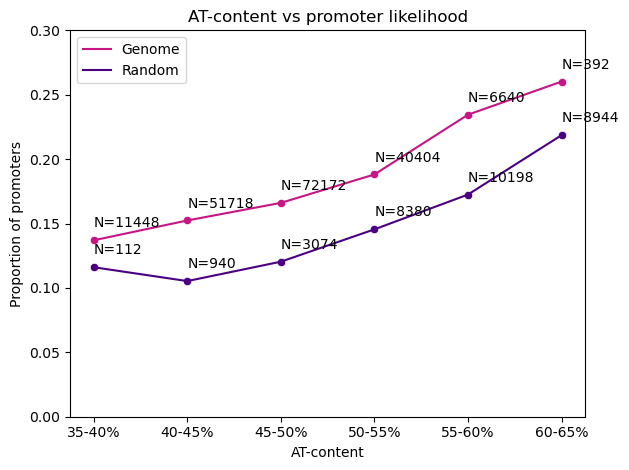

In [100]:
cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(genome_wt_df, color='mediumvioletred', label='Genome')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.3)
plt.title("AT-content vs promoter likelihood")
plt.legend()
plt.tight_layout()

plt.savefig('Fig_1C.pdf')

In [101]:
print(f'Genomic DNA is {np.mean(genome_ratios)/np.mean(random_ratios)} times more likely to encode a promoter.')

Genomic DNA is 1.2958833669195533 times more likely to encode a promoter.


### Fig 1D
Binding site frequency vs information content
(This can take a while to run...)

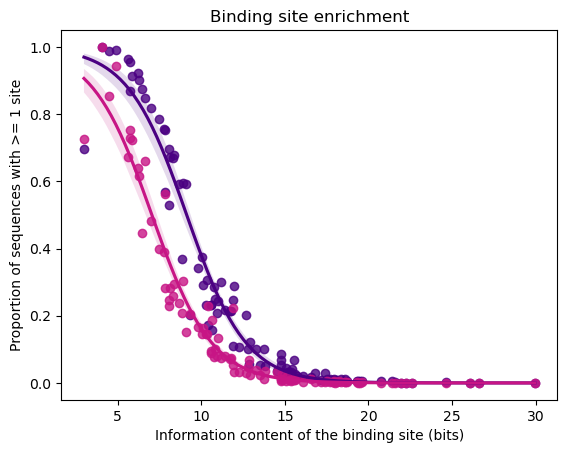

In [267]:
pwm_df = pd.DataFrame()
pwm_df['TF'] = list_of_TFs

info = []
for i, row in pwm_df.iterrows():
    information = threshold_dict[row['TF']]
    info.append(information)
pwm_df['info'] = info

### Search the random_wt_df
frequencies = []
for TF in list_of_TFs:
    #print(TF)
    
    motif_count = 0
    
    for i, row in random_wt_df.iterrows():
        sequence = row['Sequence']
        output = []
        for position, score in PSSMs_dict[TF].search(sequence, threshold=threshold_dict[TF]):
            output.append(score)
        if len(output) > 0:
            motif_count += 1
            
    motif_frequency = motif_count/len(random_wt_df)
    frequencies.append(motif_frequency)
pwm_df['rand_freq'] = frequencies

### Search the genome_wt_df
frequencies = []
for TF in list_of_TFs:
    #print(TF)
    
    motif_count = 0
    sequence_count = 0
    for i, row in genome_wt_df.iterrows():
        sequence = row['Sequence']
        if len(sequence) < 100: # This doesn't do anything...
            pass
        else:
            sequence_count +=1
            output = []
            for position, score in PSSMs_dict[TF].search(sequence, threshold=threshold_dict[TF]):
                output.append(score)
            if len(output) > 0:
                motif_count += 1
            
    motif_frequency = motif_count/sequence_count
    frequencies.append(motif_frequency)
pwm_df['gen_freq'] = frequencies

# Convert to bits from nats
bits = [n/np.log(2) for n in pwm_df['info'].to_list()]
pwm_df['bits'] = bits

sns.regplot(data = pwm_df, x='bits', y='rand_freq', color='indigo', logistic=True)
sns.regplot(data = pwm_df, x='bits', y='gen_freq', color='mediumvioletred', logistic=True)

plt.title('Binding site enrichment')
plt.ylabel("Proportion of sequences with >= 1 site")
plt.xlabel("Information content of the binding site (bits)")

plt.savefig('Fig_1D.pdf')

In [294]:
t_stat, p_value = ttest_rel(pwm_df['rand_freq'], pwm_df['gen_freq'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

print(np.mean(pwm_df['rand_freq']))
print(np.mean(pwm_df['gen_freq']))

T-statistic: 7.748575147298917
P-value: 7.484072084565255e-12
0.26332249287128007
0.15904292398604444


# Figure 2

### Dataframes (Fig 2A)

In [281]:
# The random mutagesis DNA library is called 'random_mut_df' (supplementary data 3)
print(f'There are {len(random_mut_df)} daughters in the random mut df.')
random_mut_df.head()

There are 127243 daughters in the random mut df.


sequence   parent  mutations  \
0  AACGCGAGGGCTGCACGCGATAGATGGCGTGCCATAACACTACTCC...  rand_32          6   
1  AAGAAGTAATAGGGGTGTTTTACTCGTCGGGAGATGGTGAACTGGG...  rand_25          1   
2  AAGAAGTAATAGGGGTGTTTTACTCGTCGGGAGATGGTGAACTGGG...  rand_25          4   
3  AAGAAGTAATAGGGGTGTTTTCCTCGTCGGGAGATGGTGAACTGGG...  rand_25          2   
4  AAGAAGTAATAGGGGTGTTTTCCTCGTCGGGAGATGGTGAACTGGG...  rand_25          4   

   daughters parent_ID  GFP_binary  RFP_binary  
0       7033        P0    1.000000    1.031915  
1       7033        P0    1.363636    1.000000  
2       7033        P0    1.000000    1.000000  
3       7033        P0    1.000000    1.000000  
4       7033        P0    1.000000    1.000000

In [280]:
# The genomic mutagesis DNA library is called 'genome_mut_df' (supplementary data 4)
print(f'There are {len(genome_mut_df)} daughters in the genome mut df.')
genome_mut_df.head()

There are 457330 daughters in the genome mut df.


sequence  GFP_binary  RFP_binary  \
0  TAAAAAAATCGGCATTAGAAAAAGCGCAGTCTGCCCTGGCGGAATT...         1.0         1.0   
1  TAAAAAAATCGGCATTAGAAAAAGCGCAGTCTGCCCTGGCGGAATT...         1.0         1.0   
2  TAAAAAAATCGGCATTAGAAAAAGCGCAGTCTGCCCTGGCGGAATT...         1.0         1.0   
3  TAAAAAAATCGGCATTAGAAAAAGCGCAGTCTGCCCTGGCGGAATT...         1.0         1.0   
4  TAAAAAAGATGGGTGCAATTTTACCGCCAAGGCACAAACCACCGCC...         1.0         1.0   

   coordinate matched_gene family mapped_orientation gene_orientation  \
0     4398896     ['mutL']   gene                top              top   
1     4398896     ['mutL']   gene                top              top   
2     4398896     ['mutL']   gene                top              top   
3     4398896     ['mutL']   gene                top              top   
4      132294     ['acnB']   gene             bottom              top   

   mutations   parent  
0          2  gen_162  
1          4  gen_162  
2          2  gen_162  
3          1  gen_162  
4          4  gen_218

In [289]:
print(f'We also studied the effect of {len(random_mut_df) + len(genome_mut_df)} point mutations.')

We also studied the effect of 584573 point mutations.


### Fig 2B
Pnew random DNA vs genomic DNA

In [20]:
sub_df = random_mut_df[random_mut_df['parent'] == 'rand_18']
sub_df = sub_df[sub_df['GFP_binary'] >= 1.5]
sub_df

sequence   parent  mutations  \
163     CCATGGTCAACACTTTGCATTATCCTTGGTCGTGATAGAGTGATTG...  rand_18          5   
524     TCATGGGCAACACTTTGCATTATCCTTGGTCGTGATAGAGAGATTG...  rand_18          4   
525     TCATGGGCAACACTTTGCATTATCCTTGGTCGTGATAGAGAGATTG...  rand_18          5   
526     TCATGGTCAACACTTTGCATTATCCTTGGTCGTGATAGAGTGATTG...  rand_18          2   
14353   ACATGGTCAACACTTTACATTATCCTTGATCGTGGTAGAGTGATTG...  rand_18          7   
...                                                   ...      ...        ...   
97808   TCGTGGTCAACACTTTGCATTATCCTTGGTCGCGATAGAGTGATTG...  rand_18          7   
97809   TCGTGGTCAACACTTTGCATTATCCTTGGTCGCGATAGAGTGATTG...  rand_18          4   
98946   TCTTGGTCAACACTTCGCATTATCCCTGGTCGTGATAGAGTGATTG...  rand_18          3   
98948   TCTTGGTCAACACTTTGCATTATCCTTGGTCGTGATAGAGTGATTG...  rand_18          3   
126442  TCATGGTCAACACTCTGCATTGTCATTGGTCGTGATAGAGTGATTG...  rand_18          7   

        daughters parent_ID  GFP_binary  RFP_binary  
163          7033        P0    3.988806    1.214286  
524          7033        P0    3.836364    1.093750  
525          7033        P0    3.614035    1.070175  
526          7033        P0    3.798630    1.108434  
14353        7034        P7    3.489362    1.026549  
...           ...       ...         ...         ...  
97808       21713       P49    3.990885    2.107692  
97809       21713       P49    3.987903    1.272727  
98946       21713       P49    3.088926    1.212121  
98948       21713       P49    3.951213    1.937500  
126442       5798       P62    1.988806    1.178571  

[252 rows x 7 columns]

There are 60 random parents with 127243 daughters.
There are 225 genome parents with 457330 daughters.
MWU p=1.799694117594769e-19
0.028526886976082473
0.09212708549395598


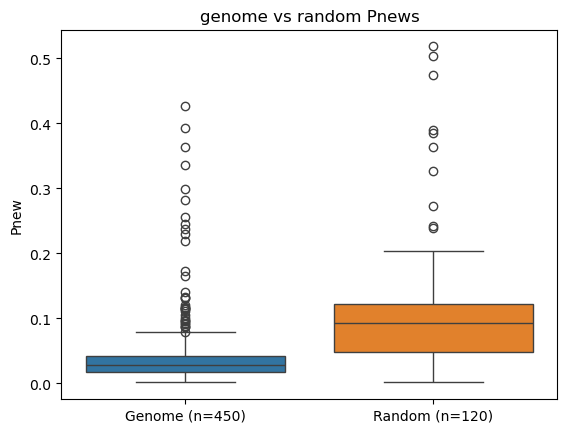

In [283]:
cutoff = 1.5

### Calculate pnew for the random parents
random_parents = list(set(random_mut_df['parent'].to_list()))
print(f'There are {len(random_parents)} random parents with {len(random_mut_df)} daughters.')
random_pnews = []
for parent in random_parents:
    sub_df = random_mut_df[random_mut_df['parent'] == parent]

    # Calculate GFP scores
    GFP_scores = sub_df['GFP_binary'].to_list()
    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    GFP_pnew = len(GFP_numerator)/len(GFP_scores)

    # Calculate RFP scores
    RFP_scores = sub_df['RFP_binary'].to_list()
    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    RFP_pnew = len(RFP_numerator)/len(RFP_scores)

    # Append to the Pnew list
    random_pnews.append(GFP_pnew)
    random_pnews.append(RFP_pnew)


### Calcualte pnew for the genomic parents
genome_parents = list(set(genome_mut_df['parent'].to_list()))
print(f'There are {len(genome_parents)} genome parents with {len(genome_mut_df)} daughters.')
genome_pnews = []
for parent in genome_parents:
    sub_df = genome_mut_df[genome_mut_df['parent'] == parent]

    # Calculate GFP scores
    GFP_scores = sub_df['GFP_binary'].to_list()
    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    GFP_pnew = len(GFP_numerator)/len(GFP_scores)

    # Calculate RFP scores
    RFP_scores = sub_df['RFP_binary'].to_list()
    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    RFP_pnew = len(RFP_numerator)/len(RFP_scores)

    # Append to the Pnew list
    genome_pnews.append(GFP_pnew)
    genome_pnews.append(RFP_pnew)


### Plot
data = [genome_pnews, random_pnews]
sns.boxplot(data=data)
plt.title('genome vs random Pnews')
plt.ylabel('Pnew')
plt.xticks(ticks=[0, 1], labels=[f"Genome (n={len(data[0])})", f"Random (n={len(data[1])})"])
plt.savefig('Fig_2B.pdf')

# Perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(data[0], data[1])
print(f'MWU p={p_value}')

print(np.median(data[0]))
print(np.median(data[1]))

### Fig 2C
Mutual information plot examples

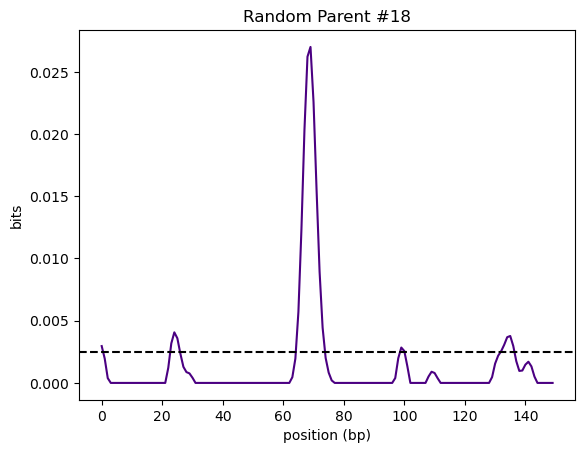

In [284]:
output = calculate_mutual_information('rand_18', 'RFP', random_mut_df, 2)
output = [max(x, 0) for x in output]

sns.lineplot(x=range(0,len(output)), y=output, color='indigo')
plt.axhline(y=0.0025, linestyle='--', color='black')
plt.ylabel('bits')
plt.xlabel('position (bp)')
plt.title(f'Random Parent #18')
plt.savefig('Fig_2C_top.pdf')

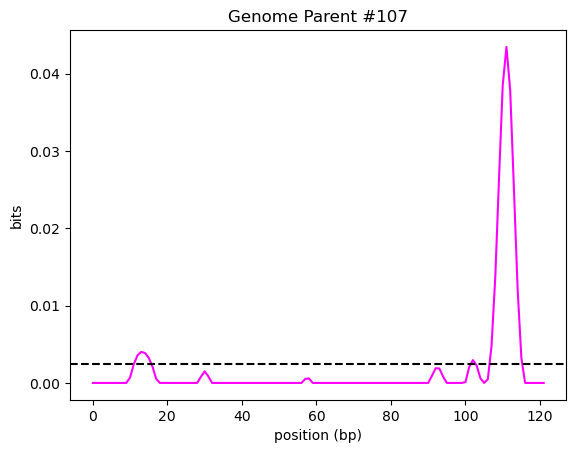

In [287]:
output = calculate_mutual_information('gen_107', 'GFP', genome_mut_df, 2)
output = [max(x, 0) for x in output]

sns.lineplot(x=range(0,len(output)), y=output, color='magenta')
plt.axhline(y=0.0025, linestyle='--', color='black')
plt.ylabel('bits')
plt.xlabel('position (bp)')
plt.title(f'Genome Parent #107')
plt.savefig('Fig_2C_bottom.pdf')

### Fig 2D
Hotspot distributions

MWU p=3.752042277179496e-12


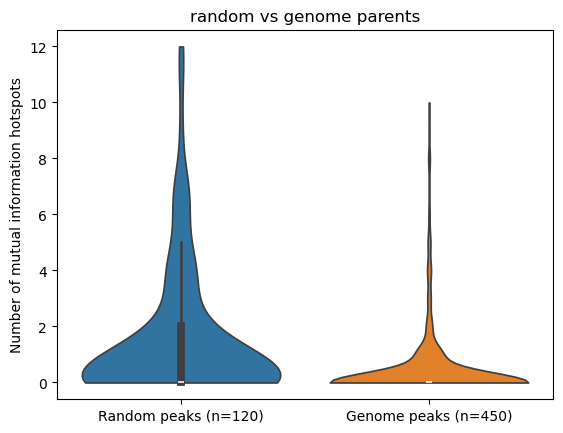

In [26]:
fluors = ['GFP', 'RFP']
genome_parents = list(set(genome_mut_df['parent'].to_list()))
random_parents = list(set(random_mut_df['parent'].to_list()))
hotspot_threshold = 0.0025

### Random parents
random_peak_counts = []
peak_sequences = []
for parent in random_parents:
    for Fluor in fluors:
        
        means = calculate_mutual_information(parent, Fluor, random_mut_df, 2)
        means = [max(x, 0) for x in means]

        min_height = hotspot_threshold

        peak_indices = find_peaks(means, min_height)
        random_peak_counts.append(len(peak_indices))
        
        #print(parent, Fluor, len(peak_indices))
        

### Genome parents
genome_peak_sequences = []
genome_peak_counts = []
for parent in genome_parents:
    for Fluor in fluors:
        
        means = calculate_mutual_information(parent, Fluor, genome_mut_df, 2)
        means = [max(x, 0) for x in means]

        min_height = hotspot_threshold
        
        peak_indices = find_peaks(means, min_height)
        genome_peak_counts.append(len(peak_indices))
                
        #print(parent, Fluor, len(peak_indices))

### Plot
data = [random_peak_counts, genome_peak_counts]
sns.violinplot(data=data, cut=0)
plt.xticks(ticks=[0, 1], labels=[f"Random peaks (n={len(data[0])})", f"Genome peaks (n={len(data[1])})"])
plt.ylabel('Number of mutual information hotspots')
plt.title('random vs genome parents')
u_statistic, p_value = mannwhitneyu(data[0], data[1])
print(f'MWU p={p_value}')

plt.savefig('Fig_2D.pdf')

In [56]:
print(f'The average random parent has {np.mean(random_peak_counts)} hotspots.')
print(f'The average genomic parent has {np.mean(genome_peak_counts)} hotspots.')

The average random parent has 1.45 hotspots.
The average genomic parent has 0.4288888888888889 hotspots.


# Figure 3

### Dataframes
These are the results from the PWM search to find associated activating and repressing sites.

In [13]:
# Gained / lost PWMs in random mutagenesis library
random_output

Orientation   Parent Fluor   PWM       P-value       ROI  N_without  \
0            top   rand_1   GFP  IclR  4.412608e-03  [67, 83]       1800   
1            top   rand_1   GFP   IHF  1.323607e-03  [38, 52]       1828   
2            top   rand_1   GFP  MraZ  3.601484e-04  [13, 21]       1782   
3            top   rand_1   GFP   Nac  1.183256e-03  [46, 63]        203   
4            top   rand_1   GFP  NsrR  4.119885e-04   [4, 19]         68   
...          ...      ...   ...   ...           ...       ...        ...   
2585         top  rand_47   RFP   HNS  1.267503e-03  [26, 36]       4497   
2586         top  rand_47   RFP   HNS  4.600277e-14  [64, 74]        790   
2587         top  rand_43   RFP   HNS  2.814753e-05  [85, 95]       1128   
2588         top  rand_17   RFP   HNS  3.727145e-03  [58, 68]        624   
2589      bottom  rand_17   GFP   HNS  2.752146e-03  [79, 89]        628   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
0         41       1.065707    1.000000  4.453880e-03    True      gain   
1         13       1.063070    1.000000  1.938994e-03    True      gain   
2         59       1.069030    1.000000  7.565161e-04    True      gain   
3       1638       1.009419    1.080582  1.790090e-03    True      loss   
4       1773       1.272727    1.055300  8.388759e-04    True      loss   
...      ...            ...         ...           ...     ...       ...   
2585     185       1.554348    2.300000  1.875905e-03    True      gain   
2586    3892       1.333333    1.600000  1.134735e-12    True      loss   
2587     118       1.025002    1.061224  9.838340e-05    True      gain   
2588      18       1.000000    1.133989  3.964396e-03    True      gain   
2589      14       1.000000    1.074631  3.225366e-03    True      gain   

      fluorescence_change  
0               -0.065707  
1               -0.063070  
2               -0.069030  
3               -0.071162  
4                0.217428  
...                   ...  
2585             0.745652  
2586            -0.266667  
2587             0.036223  
2588             0.133989  
2589             0.074631  

[2590 rows x 14 columns]

In [14]:
# Gained / lost PWMs in genomic mutagenesis library
genome_output

Orientation   Parent Fluor   PWM       P-value         ROI  N_without  \
0            top  gen_185   GFP  MraZ  2.201104e-04     [4, 12]        682   
1            top  gen_185   GFP  NarL  1.889571e-08    [12, 29]       1079   
2         bottom  gen_185   RFP  GadX  4.593432e-05   [78, 100]       1474   
3         bottom  gen_185   GFP   Fis  3.546781e-06    [73, 90]       1042   
4         bottom  gen_185   GFP  GadX  2.836251e-09   [78, 100]       1474   
...          ...      ...   ...   ...           ...         ...        ...   
1414         top  gen_121   RFP   HNS  7.557603e-07     [6, 16]        966   
1415         top   gen_28   RFP   HNS  6.112452e-04    [34, 44]        744   
1416         top   gen_28   RFP   HNS  3.474177e-07  [130, 140]        772   
1417      bottom   gen_20   RFP   HNS  6.197147e-11    [88, 98]        721   
1418      bottom   gen_20   GFP   HNS  2.088429e-05    [88, 98]        721   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
0       3666            1.0    1.000000  3.301656e-04    True      loss   
1       3269            1.0    1.000000  7.227226e-08    True      loss   
2       2874            1.0    1.000000  8.667659e-05    True      loss   
3       3306            1.0    1.000000  8.923550e-06    True      loss   
4       2874            1.0    1.000000  1.190722e-08    True      loss   
...      ...            ...         ...           ...     ...       ...   
1414      18            1.0    3.756868  2.166513e-06    True      gain   
1415      38            1.0    1.050585  7.496602e-04    True      gain   
1416      10            1.0    3.923864  1.069383e-06    True      gain   
1417      11            1.0    3.957632  3.129449e-10    True      gain   
1418      11            1.0    1.375000  4.270145e-05    True      gain   

      fluorescence_change  
0                0.000000  
1                0.000000  
2                0.000000  
3                0.000000  
4                0.000000  
...                   ...  
1414             2.756868  
1415             0.050585  
1416             2.923864  
1417             2.957632  
1418             0.375000  

[1419 rows x 14 columns]

### Fig 3A
mutual information from random parent #37

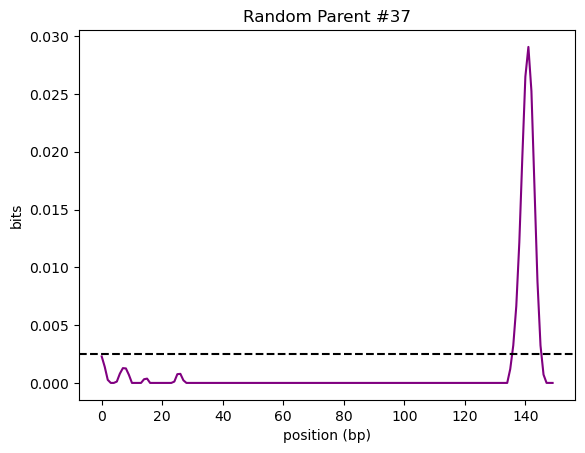

In [16]:
output = calculate_mutual_information('rand_37', 'RFP', random_mut_df, 2)
output = [max(x, 0) for x in output]

sns.lineplot(x=range(0,len(output)), y=output, color='purple')
plt.axhline(y=0.0025, linestyle='--', color='black')
plt.ylabel('bits')
plt.xlabel('position (bp)')
plt.title(f'Random Parent #37')
plt.savefig('Fig_3A.pdf')

### Fig 3B
Fluorescence scores of daughters with and without -10 binding site

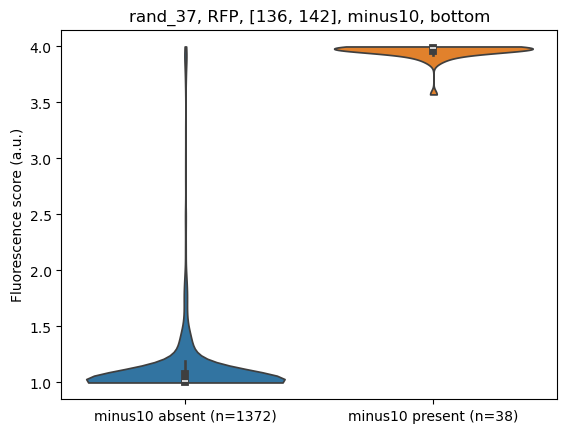

In [17]:
### KWARGS
df = random_mut_df #pandas dataframe (random_mut_df or genome_mut_df)
parent = 'rand_37' #string (see the list: "random_parents" or the list "genome_parents"
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [136, 142] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'minus10' #string: 'minus10' or 'minus35'

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
plt.savefig('Fig_3B.pdf')

In [18]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
print(sub_df['Q-value'])

2229    1.516523e-26
Name: Q-value, dtype: float64


### Fig 3C
Fluorescence increase from GAINING a site

MannwhitneyuResult(statistic=64109.5, pvalue=6.784963792349242e-31)
1.1609254284697736
1.9675221355986028


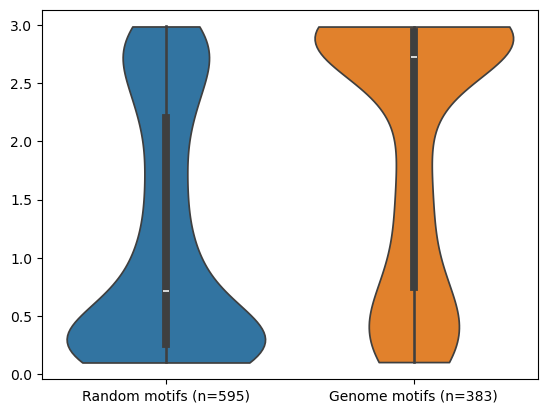

In [19]:
increase_threshold = 0.1

# Only keep 'gains' with a fluorescence change >= 0.1 au in the random parents
sub_random_output = random_output[random_output['PWM'].isin(list_of_TFs)]
sub_random_output = sub_random_output[sub_random_output['gain-loss'] == 'gain']
sub_random_output = sub_random_output[sub_random_output['fluorescence_change'] >= increase_threshold]

# Only keep 'gains' with a fluorescence change >= 0.1 au in the genomic parents
sub_genome_output = genome_output[genome_output['PWM'].isin(list_of_TFs)]
sub_genome_output = sub_genome_output[sub_genome_output['gain-loss'] == 'gain']
sub_genome_output = sub_genome_output[sub_genome_output['fluorescence_change'] >= increase_threshold]

# Plot
data = [sub_random_output['fluorescence_change'].to_list(), sub_genome_output['fluorescence_change'].to_list()]
sns.violinplot(data=data, cut=0)
plt.xticks(ticks=[0, 1], labels=[f"Random motifs (n={len(data[0])})", f"Genome motifs (n={len(data[1])})"])
output = mannwhitneyu(data[0], data[1])
print(output)

plt.savefig('Fig_3C.pdf')


print(np.mean(data[0]))
print(np.mean(data[1]))

### Fig 3D
Percentage of parents that become promoters when gaining different TF binding sites

W=27.0, p=8.252160502289531e-12


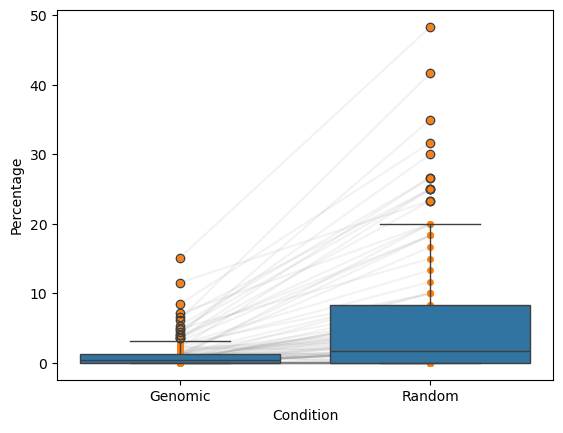

In [47]:
random_count_dictionary = {}
for TF in list_of_TFs:
    sub_df = random_output[(random_output['fluorescence_change'] >= increase_threshold) & (random_output['PWM'] == TF) & (random_output['gain-loss'] == 'gain')]
    TF_parents = list(set(sub_df['Parent'].to_list()))
    random_count_dictionary[TF] = 100*len(TF_parents)/60 # random parent sequences

genome_count_dictionary = {}
for TF in list_of_TFs:
    sub_df = genome_output[(genome_output['fluorescence_change'] >= increase_threshold) & (genome_output['PWM'] == TF) & (genome_output['gain-loss'] == 'gain')]
    TF_parents = list(set(sub_df['Parent'].to_list()))
    genome_count_dictionary[TF] = 100*len(TF_parents)/225 # Genome parent sequences

# Convert to long-format DataFrame
df = pd.DataFrame({
    'TF': list(genome_count_dictionary.keys()) * 2,
    'Condition': ['Genomic'] * len(genome_count_dictionary) + ['Random'] * len(random_count_dictionary),
    'Percentage': list(genome_count_dictionary.values()) + list(random_count_dictionary.values())
})

# Plot
sns.boxplot(data=df, x='Condition', y='Percentage')
sns.stripplot(data=df, x='Condition', y='Percentage', jitter=False, zorder=1)

# Connect paired points
for tf in df['TF'].unique():
    sub_df = df[df['TF'] == tf]
    x = [0, 1]  # 'Genomic' and 'Random' positions
    y = sub_df.sort_values(by='Condition')['Percentage'].values
    plt.plot(x, y, color='gray', alpha=0.1, zorder=0)

plt.savefig('Fig_3D.pdf')

# Wilcoxon signed-rank test
genomic_vals = [genome_count_dictionary[tf] for tf in genome_count_dictionary]
random_vals = [random_count_dictionary[tf] for tf in genome_count_dictionary]
stat, p_value = wilcoxon(genomic_vals, random_vals)
print(f'W={stat}, p={p_value}')

In [42]:
print(f'{genome_count_dictionary['minus10']:.2f}% of the GENOMIC parents become promoters upon gaining a -10 box.')
print(f'{random_count_dictionary['minus10']:.2f}% of the RANDOM parents become promoters upon gaining a -10 box.')

15.11% of the GENOMIC parents become promoters upon gaining a -10 box.
48.33% of the RANDOM parents become promoters upon gaining a -10 box.


In [43]:
print(f'{genome_count_dictionary['minus35']:.2f}% of the GENOMIC parents become promoters upon gaining a -35 box.')
print(f'{random_count_dictionary['minus35']:.2f}% of the RANDOM parents become promoters upon gaining a -35 box.')

11.56% of the GENOMIC parents become promoters upon gaining a -35 box.
23.33% of the RANDOM parents become promoters upon gaining a -35 box.


### Fig 3E
Average proto-sites per parent

W=72.0, p=1.496923100064229e-17


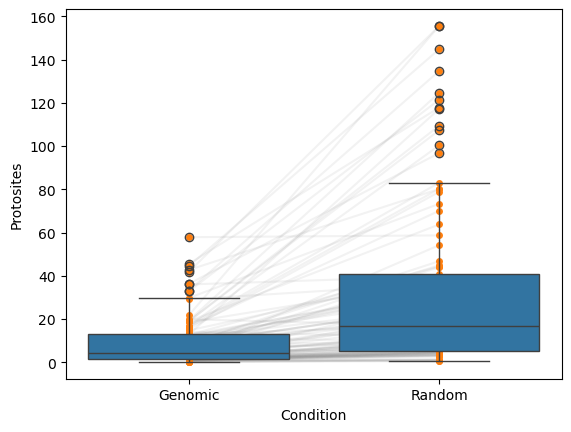

In [48]:
### Get the average number of protosites
random_TF_dict = {} #Mean number of protosites per parent
for TF in list_of_TFs:
    present_count = 0
    total_parents = 0
    for record in SeqIO.parse("fasta/random_parents.fasta", "fasta"):
        total_parents +=1
        output = []
        for position, score in PSSMs_dict[TF].search(record.seq):
            if score < threshold_dict[TF]:
                output.append(score)
                present_count+=len(output)

    random_TF_dict[TF] = present_count / total_parents

genome_TF_dict = {} #Mean number of protosites per parent
for TF in list_of_TFs:
    present_count = 0
    total_parents = 0
    for record in SeqIO.parse("fasta/genome_parents.fasta", "fasta"):
        total_parents +=1
        output = []
        for position, score in PSSMs_dict[TF].search(record.seq):
            if score < threshold_dict[TF]:
                output.append(score)
                present_count+=len(output)

    genome_TF_dict[TF] = present_count / total_parents

# Convert to long-format DataFrame
df = pd.DataFrame({
    'TF': list(genome_TF_dict.keys()) * 2,
    'Condition': ['Genomic'] * len(genome_TF_dict) + ['Random'] * len(random_TF_dict),
    'Protosites': list(genome_TF_dict.values()) + list(random_TF_dict.values())
})

# Plot
sns.boxplot(data=df, x='Condition', y='Protosites')
sns.stripplot(data=df, x='Condition', y='Protosites', jitter=False, zorder=1)

# Connect paired points
for tf in df['TF'].unique():
    sub_df = df[df['TF'] == tf]
    x = [0, 1]  # 'Genomic' and 'Random' positions
    y = sub_df.sort_values(by='Condition')['Protosites'].values
    plt.plot(x, y, color='gray', alpha=0.1, zorder=0)

plt.savefig('Fig_3E.pdf')

# Run Wilcoxon signed-rank test
from scipy.stats import wilcoxon
genomic_vals = [genome_TF_dict[tf] for tf in genome_TF_dict]
random_vals = [random_TF_dict[tf] for tf in random_TF_dict]
stat, p_value = wilcoxon(genomic_vals, random_vals)
print(f'W={stat}, p={p_value}')

In [36]:
print(np.median(genomic_vals))
print(np.median(random_vals))

4.3933333333333335
16.858333333333334


# Figure 4

### Dataframes
Takes random_output or genome_output and looks solely at cases where PWMs are lost, the fluorescence change > 0, and solely at TFs (no sigma factors). Also identifies which parents are repressed for "Fig 4A"

In [20]:
random_repression = random_output[(random_output['gain-loss'] == 'loss') & (random_output['fluorescence_change'] > 0) & (~random_output['PWM'].str.contains('sig')) & (~random_output['PWM'].str.contains('minus'))]
repressed_random_parents = list(set(random_repression['Parent'].to_list()))
print(f'{len(repressed_random_parents)} of the random parents are repressd')

genome_repression = genome_output[(genome_output['gain-loss'] == 'loss') & (genome_output['fluorescence_change'] > 0 ) & (~genome_output['PWM'].str.contains('sig')) & (~genome_output['PWM'].str.contains('minus'))]
repressed_genome_parents = list(set(genome_repression['Parent'].to_list()))
print(f'{len(repressed_genome_parents)} of the genomic parents are repressd')

35 of the random parents are repressd
11 of the genomic parents are repressd


### Fig 4A
Pie charts

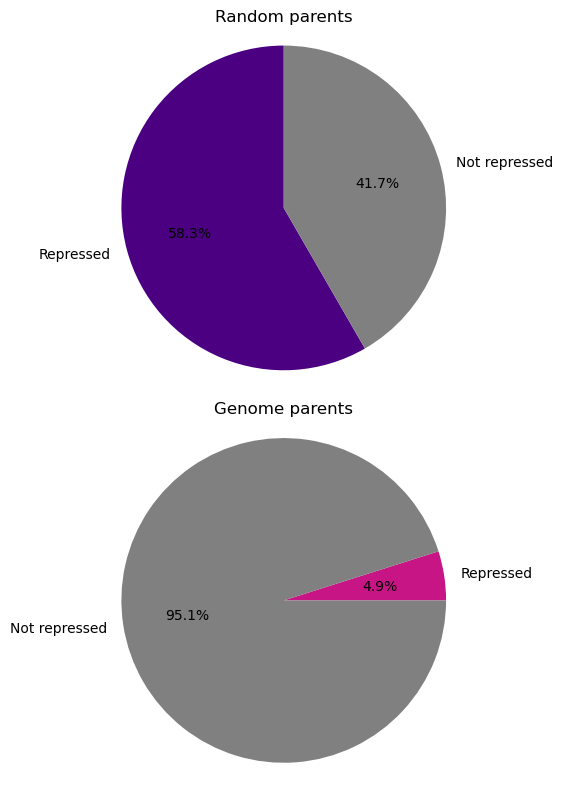

In [381]:
# Prepare data
sizes1 = [len(repressed_random_parents), 60 - len(repressed_random_parents)]
sizes2 = [len(repressed_genome_parents), 225 - len(repressed_genome_parents)]

labels = ['Repressed', 'Not repressed']
colors1 = ['indigo', 'gray']
colors2 = ['mediumvioletred', 'gray']

# Create subplots
fig, axes = plt.subplots(nrows=2, figsize=(5, 8))  # 2 rows, 1 column

# First pie chart: Random parents
axes[0].pie(sizes1, labels=labels, colors=colors1, startangle=90, autopct='%1.1f%%')
axes[0].axis('equal')
axes[0].set_title("Random parents")

# Second pie chart: Genome parents
axes[1].pie(sizes2, labels=labels, colors=colors2, startangle=0, autopct='%1.1f%%')
axes[1].axis('equal')
axes[1].set_title("Genome parents")

plt.tight_layout()
plt.savefig('Fig_4A.pdf')

### Fig 4B
Repression strength

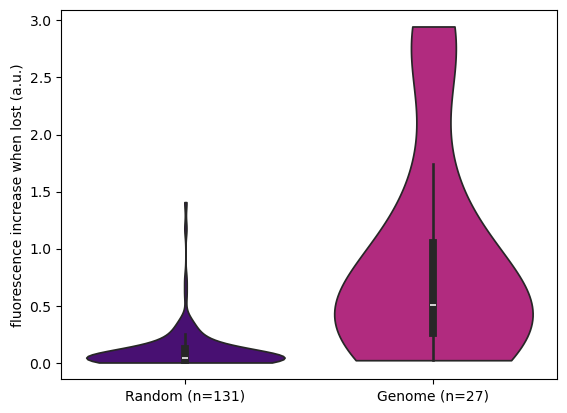

In [24]:
data = [random_repression['fluorescence_change'].to_list(), genome_repression['fluorescence_change'].to_list()]
sns.violinplot(data=data, palette=['indigo', 'mediumvioletred'], cut=0)
plt.ylabel('fluorescence increase when lost (a.u.)')
plt.xticks(ticks=[0, 1], labels=[f"Random (n={len(data[0])})", f"Genome (n={len(data[1])})"])
#plt.savefig('repression_strength.pdf')

output = mannwhitneyu(data[0], data[1])
output
plt.savefig('Fig_4B.pdf')

In [25]:
print(np.median(data[0]))
print(np.median(data[1]))
print(output)

0.0413602941176469
0.5101604278074867
MannwhitneyuResult(statistic=401.0, pvalue=2.7090719525002683e-10)


### Fig 4C
Number of associated repressing sites

40


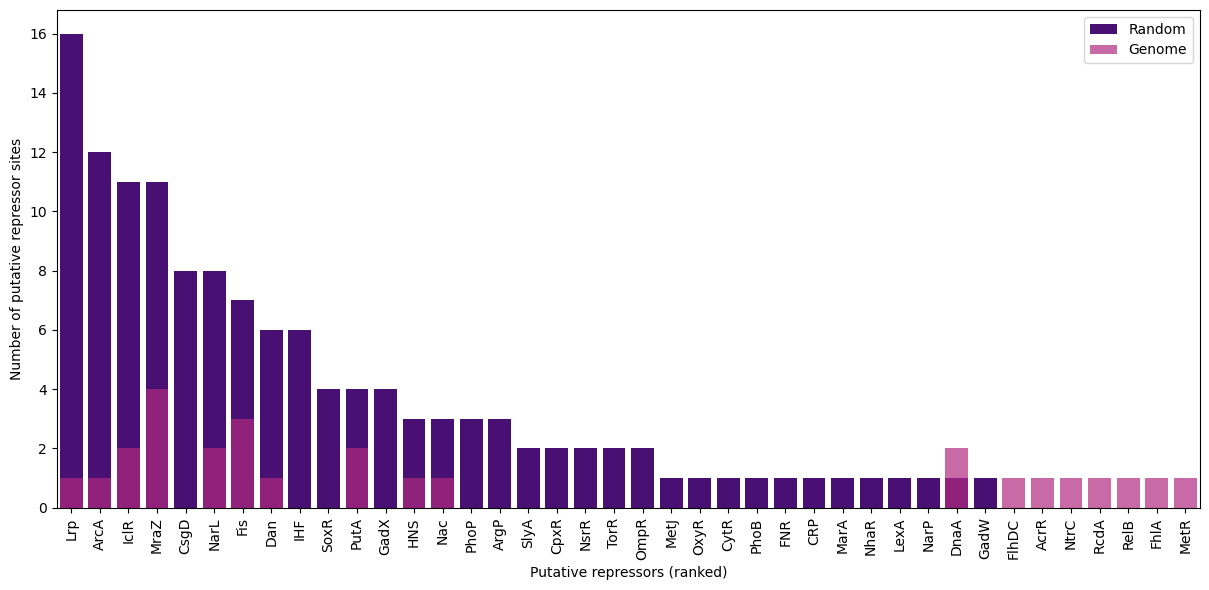

In [22]:
genome_repressors = set(genome_repression['PWM'])
random_repressors = set(random_repression['PWM'])

genome_loss_pwm_counts = Counter(genome_repression['PWM'].to_list())
random_loss_pwm_counts = Counter(random_repression['PWM'].to_list())

# Convert to Series if needed
random_series = pd.Series(random_loss_pwm_counts)
genome_series = pd.Series(genome_loss_pwm_counts)

# Sort TFs by random_series in descending order
sorted_tfs = random_series.sort_values(ascending=False).index.tolist()  # Convert to list
# Add values exclusively from the genome...
for genome in genome_repressors:
    if genome not in random_repressors:
        sorted_tfs.append(genome)

print(len(sorted_tfs))

# Reindex both Series to match sorted order
random_sorted = random_series.reindex(sorted_tfs)
genome_sorted = genome_series.reindex(sorted_tfs)

# Plot both (overlayed bars)
plt.figure(figsize=(12, 6))
sns.barplot(x=random_sorted.index, y=random_sorted.values, color='indigo', label='Random')
sns.barplot(x=genome_sorted.index, y=genome_sorted.values, color='mediumvioletred', label='Genome', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel('Number of putative repressor sites')
plt.xlabel('Putative repressors (ranked)')

plt.savefig('Fig_4C.pdf')

### Fig 4D
Venn diagram

The followiong are repressing exclusively in the genome:
FlhDC
AcrR
NtrC
RcdA
RelB
FhlA
MetR

The following are repressing exclusively in the random parents:
LexA
TorR
OmpR
CpxR
NhaR
SoxR
NarP
GadW
IHF
MetJ
ArgP
FNR
PhoP
PhoB
SlyA
GadX
CytR
CsgD
CRP
OxyR
MarA
NsrR
The following TFs repress in the genome:
{'NarL', 'FlhDC', 'Fis', 'Dan', 'HNS', 'AcrR', 'DnaA', 'NtrC', 'ArcA', 'RcdA', 'PutA', 'IclR', 'RelB', 'Nac', 'FhlA', 'MraZ', 'Lrp', 'MetR'}
The following TFs repress in the random DNA:
{'LexA', 'TorR', 'Dan', 'PutA', 'OmpR', 'CpxR', 'NhaR', 'SoxR', 'Fis', 'NarP', 'GadW', 'ArcA', 'IclR', 'IHF', 'MetJ', 'ArgP', 'FNR', 'MraZ', 'PhoP', 'PhoB', 'SlyA', 'HNS', 'DnaA', 'GadX', 'CytR', 'Lrp', 'CsgD', 'CRP', 'OxyR', 'Nac', 'MarA', 'NarL', 'NsrR'}


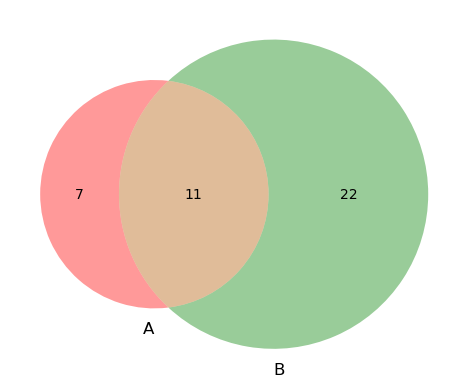

In [23]:
print("The followiong are repressing exclusively in the genome:")
for genome in genome_repressors:
    if genome in random_repressors:
        pass
    else:
        print(genome)

print()
print("The following are repressing exclusively in the random parents:")
for random in random_repressors:
    if random in genome_repressors:
        pass
    else:
        print(random)




print(f'The following TFs repress in the genome:')
print(genome_repressors)

print(f'The following TFs repress in the random DNA:')
print(random_repressors)

venn2(subsets = (7, 22, 11))
plt.savefig('Fig_4D.pdf')

### Fig 4E
Mutual information and number of sites

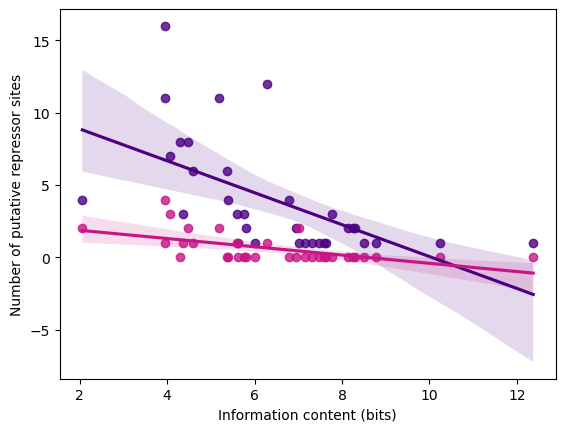

In [28]:
information = []
random_counts = []
genome_counts = []

sublist_of_TFs = list(set(random_repression['PWM'].to_list()))
for TF in sublist_of_TFs:
    information.append(threshold_dict[TF])
    random_counts.append(random_loss_pwm_counts[TF])

    if TF in genome_loss_pwm_counts:
        genome_counts.append(genome_loss_pwm_counts[TF])
    else:
        genome_counts.append(0)

sns.regplot(x=information, y=random_counts, color='indigo')
sns.regplot(x=information, y=genome_counts, color='mediumvioletred')
plt.ylabel('Number of putative repressor sites')
plt.xlabel('Information content (bits)')
plt.savefig('Fig_4E.pdf')

In [29]:
### Line of best fit and linear regression for random parents
slope, intercept, r_value, p_value, std_err = linregress(information, random_counts)
print(f"Equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Pearson correlation: {r_value}, p-value: {p_value}")

Equation: y = -1.103x + 11.087
Pearson correlation: -0.5829436695267805, p-value: 0.0003707906192869653


In [30]:
### Line of best fit and linear regression for random parents
slope, intercept, r_value, p_value, std_err = linregress(information, genome_counts)
print(f"Equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Pearson correlation: {r_value}, p-value: {p_value}")

Equation: y = -0.285x + 2.448
Pearson correlation: -0.5719589094550149, p-value: 0.0005062070537344577


# Figure S1

### S1A
length of sequences in library

mean length: 129.71768663052708 bp
std: 23.256530002093925 bp


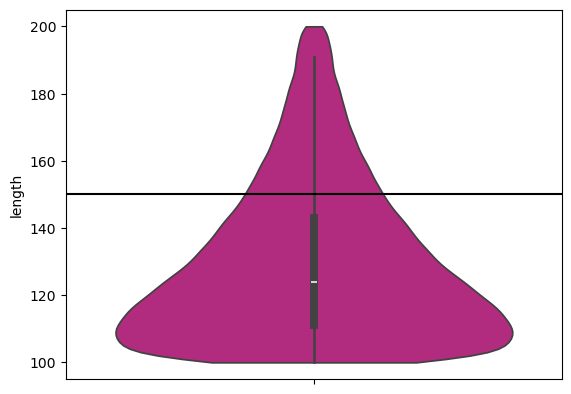

In [253]:
# Calculate the length of each sequence
genome_lengths = []
for i, row in genome_wt_df.iterrows():
    sequence = row['Sequence']
    genome_lengths.append(len(sequence))
genome_wt_df['length'] = genome_lengths

# Plot
sns.violinplot(data=genome_wt_df, y='length', color='mediumvioletred', cut=0)
plt.axhline(y=150, color='black')

# Print stuff
print(f'mean length: {np.mean(genome_wt_df['length'])} bp')
print(f'std: {np.std(genome_wt_df['length'])} bp')

plt.savefig('Fig_S1A.pdf')

### S1B
calculate sequence coverage

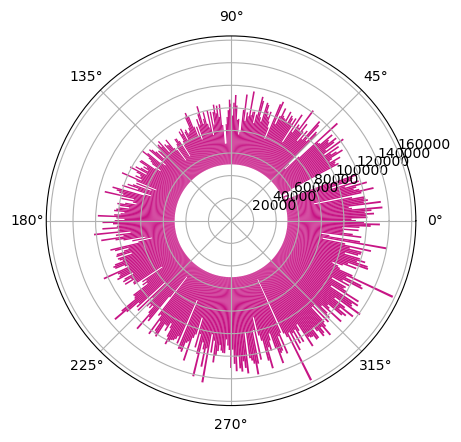

In [254]:
# Compute the histogram using numpy
hist, bin_edges = np.histogram(genome_wt_df['coordinate'], bins=500)

#https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python
N = len(hist)
bottom = 50000
max_height = 300
    
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = [max_height*n for n in hist]
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom, color='mediumvioletred')

plt.savefig("Fig_S1B.pdf")

### S1C
Fluorescence vs sequence length

Equation: y = 0.000x + 1.189
Pearson correlation: 0.010657928983289655, p-value: 4.912030850969741e-06


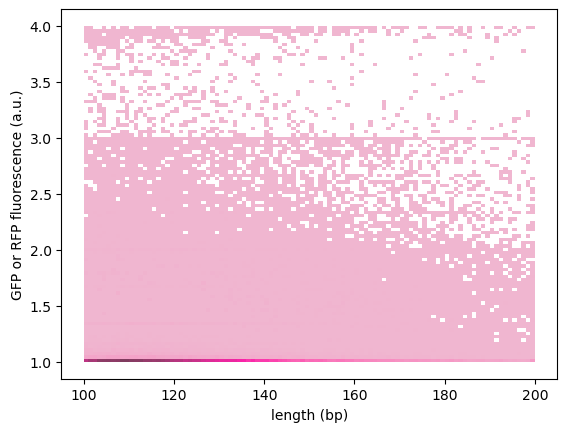

In [255]:
lengths = genome_wt_df['length'].to_list() + genome_wt_df['length'].to_list() # Because you're comparing both GFP and RFP, need to double
fluorescences = genome_wt_df['GFP_mean'].to_list() + genome_wt_df['RFP_mean'].to_list()
slope, intercept, r_value, p_value, std_err = linregress(lengths, fluorescences)
print(f"Equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Pearson correlation: {r_value}, p-value: {p_value}")

# Plot
sns.histplot(data=genome_wt_df, x='length', y='GFP_mean', color='mediumvioletred', bins=100)
sns.histplot(data=genome_wt_df, x='length', y='RFP_mean', color='mediumvioletred', bins=100)
plt.ylabel('GFP or RFP fluorescence (a.u.)')
plt.xlabel('length (bp)')

plt.savefig('Fig_S1C.pdf')

### S1D
Shannon entropy random library

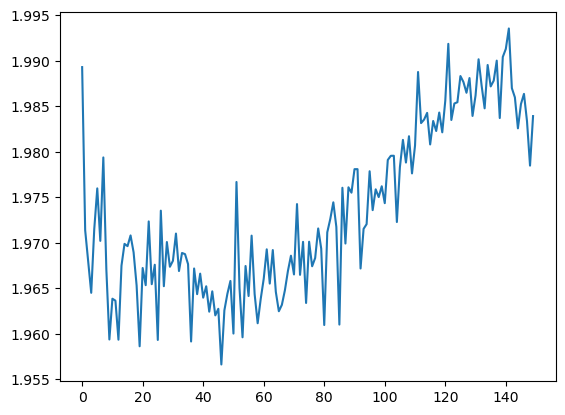

In [257]:
def shannon_entropy(sequences):
    sequence_length = len(sequences[0])  # Assume all sequences have the same length
    entropy_values = []

    for i in range(sequence_length):
        column = [seq[i] for seq in sequences]  # Extract nucleotides at position i
        counts = Counter(column)
        total = len(column)
        probabilities = [count / total for count in counts.values()]
        entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
        entropy_values.append(entropy)

    return entropy_values  # Returns entropy per position

random_entropy = shannon_entropy(random_wt_df['Sequence'].to_list())

# Plot
sns.lineplot(x=range(0,len(random_entropy)), y=random_entropy)

plt.savefig('Fig_S1D_top.pdf')

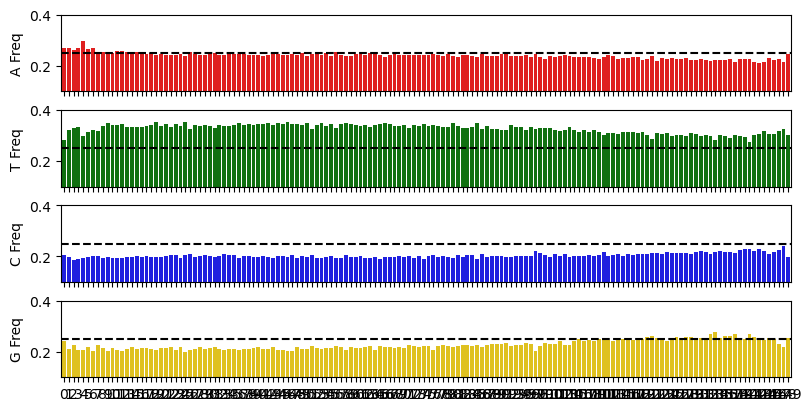

In [258]:
### individual frequencies (this takes a few minutes...)

bases = ['A','T','C','G']

A_freqs = []
T_freqs = []
C_freqs = []
G_freqs = []
for i in range(150):
    #print(i)
    for j in bases:
        numerator = 0
        for n, row in random_wt_df.iterrows():
            sequence = row['Sequence']
            base_n = sequence[i]
            if base_n == j:
                numerator +=1

        if j == 'A':
            A_freqs.append(numerator/len(random_wt_df))
        elif j == 'T':
            T_freqs.append(numerator/len(random_wt_df))
        elif j == 'C':
            C_freqs.append(numerator/len(random_wt_df))
        elif j == 'G':
            G_freqs.append(numerator/len(random_wt_df))

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 4), constrained_layout=True)

# Plot each frequency distribution as a stacked bar plot
sns.barplot(x=range(150), y=A_freqs, ax=axes[0], color="red")
sns.barplot(x=range(150), y=T_freqs, ax=axes[1], color="green")
sns.barplot(x=range(150), y=C_freqs, ax=axes[2], color="blue")
sns.barplot(x=range(150), y=G_freqs, ax=axes[3], color="gold")

# Set y-limits for all subplots
for ax in axes:
    ax.set_ylim(0.1, 0.4)
    ax.axhline(y=0.25, color='black', linestyle='--')

axes[0].set_ylabel("A Freq")
axes[1].set_ylabel("T Freq")
axes[2].set_ylabel("C Freq")
axes[3].set_ylabel("G Freq")  

plt.savefig('Fig_S1D_bottom.pdf')

### S1E
Fluorescence distributions

Counter({'Inactive': 11435, 'GFP_only': 4649, 'RFP_only': 684, 'Bidirectional': 361})


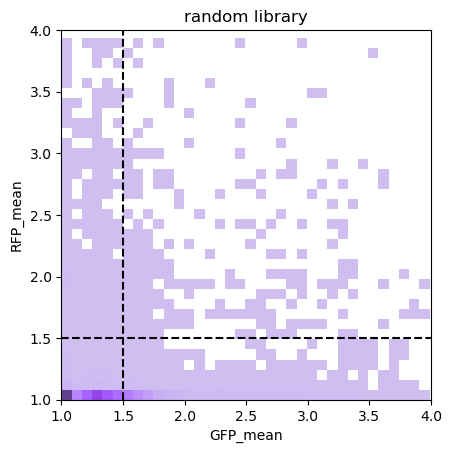

In [259]:
### Complete random library
x_values = random_wt_df['GFP_mean']
y_values = random_wt_df['RFP_mean']
        
# Create scatter plot with different colors for different categories
sns.histplot(x=x_values, y=y_values, color='indigo', bins=36)
plt.axhline(y=cutoff, color='black', linestyle='--')
plt.axvline(x=cutoff, color='black', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(1,4)
plt.xlim(1,4)
plt.title('random library')

# Get counts:
counts = []
for x, y in zip(x_values, y_values):
    if x >= cutoff and y >= cutoff:
        counts.append('Bidirectional')
    elif x >= cutoff and y<cutoff:
        counts.append('GFP_only')
    elif y >= cutoff and x<cutoff:
        counts.append('RFP_only')
    else:
        counts.append('Inactive')
random_category_counts = Counter(counts)
print(random_category_counts)

plt.savefig('Fig_S1E_random_library.pdf')

Counter({'Inactive': 62750, 'GFP_only': 23012, 'RFP_only': 4394, 'Bidirectional': 1710})


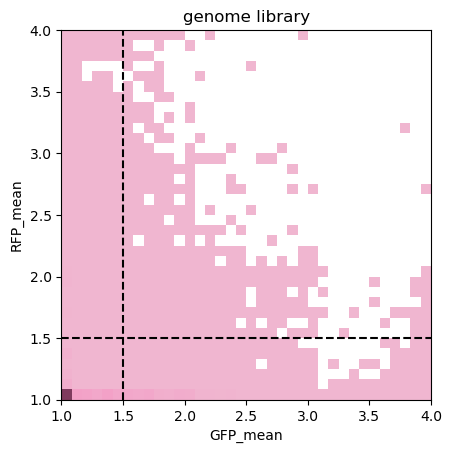

In [292]:
### Complete genomic library
x_values = genome_wt_df['GFP_mean']
y_values = genome_wt_df['RFP_mean']

sns.histplot(x=x_values, y=y_values, color='mediumvioletred', bins=36)
plt.axhline(y=cutoff, color='black', linestyle='--')
plt.axvline(x=cutoff, color='black', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(1,4)
plt.xlim(1,4)
plt.title("genome library")

# Categorize points based on their x and y values
counts = []
for x, y in zip(x_values, y_values):
    if x >= cutoff and y >= cutoff:
        counts.append('Bidirectional')
    elif x >= cutoff:
        counts.append('GFP_only')
    elif y >= cutoff:
        counts.append('RFP_only')
    else:
        counts.append('Inactive')

genome_category_counts = Counter(counts)
print(genome_category_counts)

plt.savefig('Fig_S1E_complete_genomic_library.pdf')

Counter({'Inactive': 480, 'GFP_only': 176, 'RFP_only': 40, 'Bidirectional': 12})
708


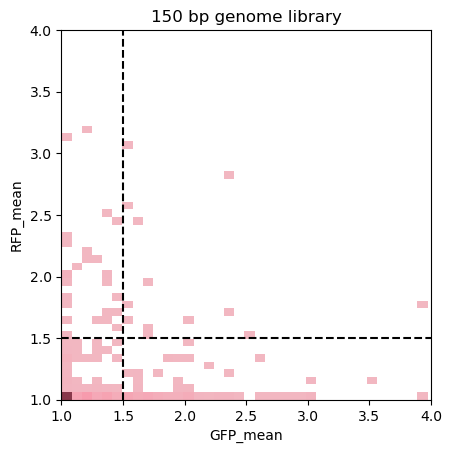

In [261]:
### 150-bp genomic library
sub_df = genome_wt_df[genome_wt_df['length'] == 150]
sns.histplot(data=sub_df, x='GFP_mean', y='RFP_mean', color='pink', bins=36)
plt.axhline(y=1.5, color='black', linestyle='--')
plt.axvline(x=1.5, color='black', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(1,4)
plt.xlim(1,4)
plt.title("150 bp genome library")

x_values = sub_df['GFP_mean'].to_list()
y_values = sub_df['RFP_mean'].to_list()

# Categorize points based on their x and y values
counts = []
for x, y in zip(x_values, y_values):
    if x >= 1.5 and y >= 1.5:
        counts.append('Bidirectional')
    elif x >= 1.5:
        counts.append('GFP_only')
    elif y >= 1.5:
        counts.append('RFP_only')
    else:
        counts.append('Inactive')

category_counts = Counter(counts)
print(category_counts)

print(len(sub_df))
plt.savefig('Fig_S1E_150_genomic_library.pdf')

### S1F
GC-contents

T-test p=0.0
0.0
53.185300212265886
4.6053744563707415
43.17010138751046
5.946959526858015


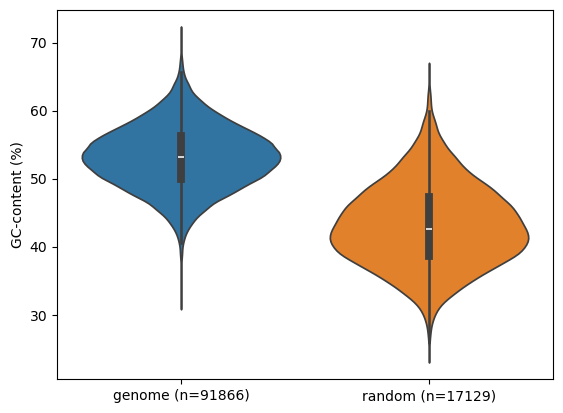

In [262]:
genome_GC = []
for i, row in genome_wt_df.iterrows():
    sequence = row['Sequence']
    seq_GC = gc_fraction(sequence)*100
    genome_GC.append(seq_GC)

random_GC = []
for i, row in random_wt_df.iterrows():
    sequence = row['Sequence']
    seq_GC = gc_fraction(sequence)*100
    random_GC.append(seq_GC)

data = [genome_GC, random_GC]
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1], labels=[f"genome (n={len(data[0])})", f"random (n={len(data[1])})"])
plt.ylabel('GC-content (%)')
u_statistic, p_value = ttest_ind(data[0], data[1])
print(f'T-test p={p_value}')
print(p_value)

# print(np.mean(genome_GC))
# print(np.mean(random_GC))

print(np.mean(genome_GC))
print(np.std(genome_GC))

print(np.mean(random_GC))
print(np.std(random_GC))

plt.savefig("Fig_S1F.pdf")

### S1G

In [264]:
#pwm_df = pd.read_csv('pwm_df.csv')

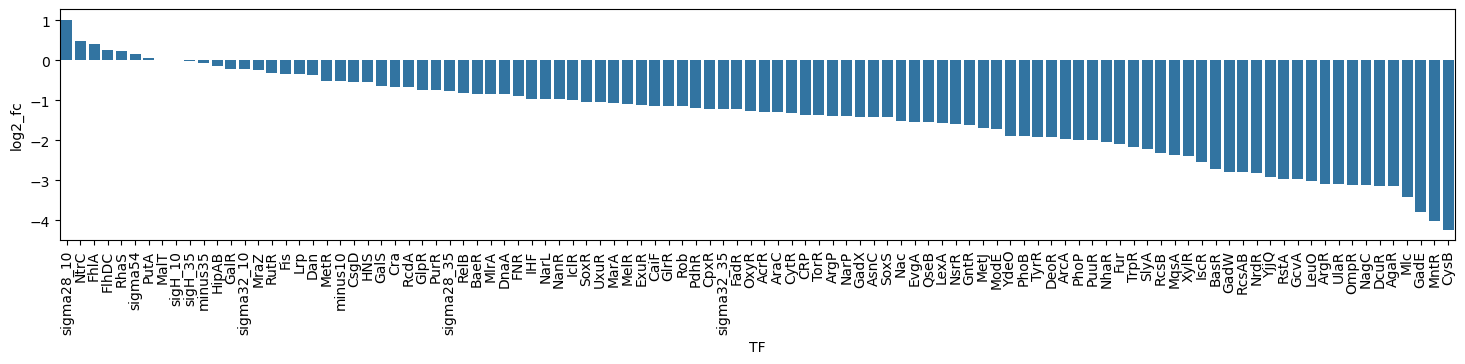

In [265]:
if pwm_df is None:
    print('Please run the cell "Fig1D" to proceed with this analysis.')
else:

    # Calcualte log2 fold-change column
    pwm_df['log2_fc'] = np.log2(pwm_df['gen_freq'] / pwm_df['rand_freq'])
    pwm_df = pwm_df.sort_values('log2_fc', ascending=False)

    # Plot
    plt.figure(figsize=(18, 3))
    sns.barplot(data=pwm_df, x='TF', y='log2_fc')
    plt.xticks(rotation=90)
    plt.savefig('Fig_S1G.pdf')

# Figure S2

### S2A
Non-coding "intergenic" DNA only and AT-content

In [295]:
# Get truly intergenic sequences
intergenic_or_not = []
for i, row in genome_wt_df.iterrows():
    
    # Get the sequence, strand, and start coordinate
    query_seq = str(row['Sequence'])
    strand = row['strand']
    start = int(row['coordinate'])

    if strand == 'bottom':
        query_seq = str(Seq(query_seq).reverse_complement())

    # Remove the T on the 5'end and the A on the 3' end
    query_seq = query_seq[1:-1]

    # Calculate end coordinate (exclusive)
    end = start + len(query_seq)

    # Flag to track if any overlap was found
    overlap_found = False

    # Check against all gene coordinates
    for value in element_coordinate_d.values():
        match = re.match(r"\[(\d+):(\d+)\]\(([-+])\)", value)
        if match:
            gene_start = int(match.group(1))
            gene_end = int(match.group(2))
            gene_strand = match.group(3)

            # Check for no overlap
            no_overlap = end <= gene_start or gene_end <= start
            if not no_overlap:
                overlap_found = True
                intergenic_or_not.append('not')
                break

    # If no overlaps were found after checking all elements
    if not overlap_found:
        intergenic_or_not.append('intergenic')

# Add this information to the genome_wt_df
genome_wt_df['intergenic_or_not'] = intergenic_or_not

964


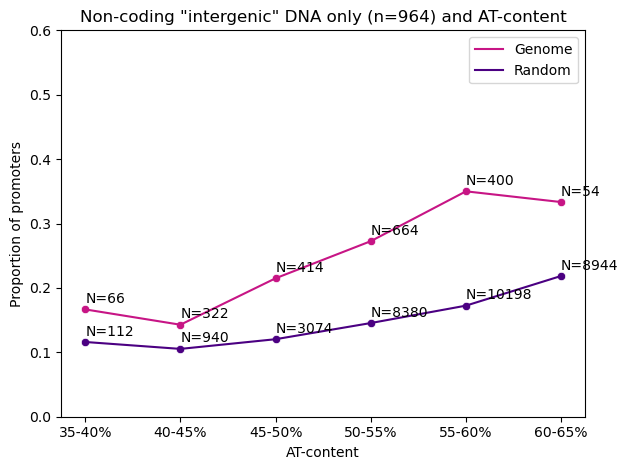

In [299]:
# Create a dataframe which only contains intergenic sequences
sub_df = genome_wt_df[genome_wt_df['intergenic_or_not'] == 'intergenic']
print(len(sub_df))

cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(sub_df, color='mediumvioletred', label='Genome')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.6)
plt.title(f'Non-coding "intergenic" DNA only (n={len(sub_df)}) and AT-content')
plt.legend()
plt.tight_layout()

plt.savefig('Fig_S2A.pdf')

In [300]:
print(np.mean(genome_ratios))
print(np.mean(random_ratios))

0.246737224952259
0.1463812346959586


### S2B
intragenic only

In [297]:
intragenic_or_not = []
for i, row in genome_wt_df.iterrows():
    
    # Get the sequence, strand, and start coordinate
    query_seq = str(row['Sequence'])
    strand = row['strand']
    start = int(row['coordinate'])

    if strand == 'bottom':
        query_seq = str(Seq(query_seq).reverse_complement())

    # Remove the T on the 5'end and the A on the 3' end
    query_seq = query_seq[1:-1]

    # Calculate end coordinate (exclusive)
    end = start + len(query_seq)

    # Flag to track if fully contained in any gene
    fully_contained = False

    for value in element_coordinate_d.values():
        match = re.match(r"\[(\d+):(\d+)\]\(([-+])\)", value)
        if match:
            gene_start = int(match.group(1))
            gene_end = int(match.group(2))
            gene_strand = match.group(3)

            # Check if query is fully contained in gene
            if gene_start <= start and end <= gene_end:
                fully_contained = True
                break

    if fully_contained:
        intragenic_or_not.append('intragenic')
    else:
        intragenic_or_not.append('not')

# Add to genome_wt_df
genome_wt_df['intragenic_or_not'] = intragenic_or_not

80622


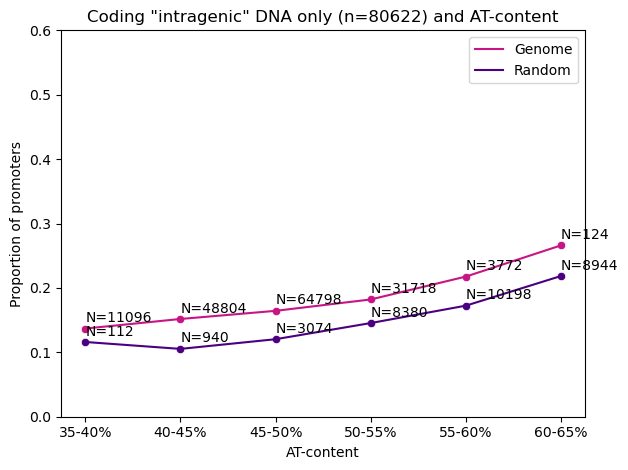

In [301]:
# Create a dataframe which only contains intergenic sequences
sub_df = genome_wt_df[genome_wt_df['intragenic_or_not'] == 'intragenic']
print(len(sub_df))

cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(sub_df, color='mediumvioletred', label='Genome')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.6)
plt.title(f'Coding "intragenic" DNA only (n={len(sub_df)}) and AT-content')
plt.legend()
plt.tight_layout()

plt.savefig('Fig_S2B.pdf')

In [302]:
print(np.mean(genome_ratios))
print(np.mean(random_ratios))

0.18649590448043116
0.1463812346959586


### S2C
sense vs antisense

['N=5548', 'N=24402', 'N=32399', 'N=15859', 'N=1886', 'N=62']
['N=5548', 'N=24402', 'N=32399', 'N=15859', 'N=1886', 'N=62']
['N=112', 'N=940', 'N=3074', 'N=8380', 'N=10198', 'N=8944']


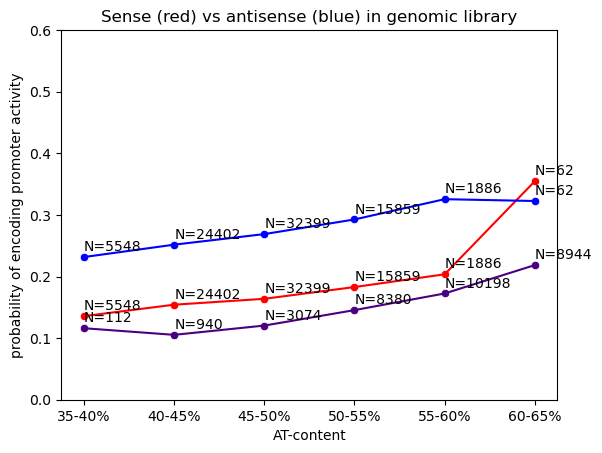

In [303]:
### Sense first

bin_35_40 = []
bin_40_45 = []
bin_45_50 = []
bin_50_55 = []
bin_55_60 = []
bin_60_65 = []
bin_65_70 = []
bin_70_75 = []

for i, row in sub_df.iterrows():
    sequence = row['Sequence']
    seq_GC = gc_fraction(sequence)*100
    seq_AT = 100-seq_GC
    strand = row['strand']
    
    # Append GFP and RFP scores to this list
    if seq_AT >= 35 and seq_AT < 40:
        if strand == 'top':
            bin_35_40.append(row['GFP_mean'])
        elif strand == 'bottom':
            bin_35_40.append(row['RFP_mean'])
        
    elif seq_AT >= 40 and seq_AT < 45:
        if strand == 'top':
            bin_40_45.append(row['GFP_mean'])
        elif strand == 'bottom':
            bin_40_45.append(row['RFP_mean'])
        
    elif seq_AT >=45 and seq_AT < 50:
        if strand == 'top':
            bin_45_50.append(row['GFP_mean'])
        elif strand == 'bottom':
            bin_45_50.append(row['RFP_mean'])
        
    elif seq_AT >=50 and seq_AT < 55:
        if strand == 'top':
            bin_50_55.append(row['GFP_mean'])
        elif strand == 'bottom':
            bin_50_55.append(row['RFP_mean'])
        
    elif seq_AT >=55 and seq_AT < 60:
        if strand == 'top':
            bin_55_60.append(row['GFP_mean'])
        elif strand == 'bottom':
            bin_55_60.append(row['RFP_mean'])

    elif seq_AT >=60 and seq_AT < 65:
        if strand == 'top':
            bin_60_65.append(row['GFP_mean'])
        elif strand == 'bottom':
            bin_60_65.append(row['RFP_mean'])
        
    elif seq_AT >=65 and seq_AT < 70:
        if strand == 'top':
            bin_65_70.append(row['GFP_mean'])
        elif strand == 'bottom':
            bin_65_70.append(row['RFP_mean'])
        
# How many of the scores are greater than 1.5?
def active_ratio(scores):
    ratio = [n for n in scores if n >= cutoff]
    ratio = len(ratio) / len(scores)
    return ratio

ratio_35_40 = active_ratio(bin_35_40)
ratio_40_45 = active_ratio(bin_40_45)
ratio_45_50 = active_ratio(bin_45_50)
ratio_50_55 = active_ratio(bin_50_55)
ratio_55_60 = active_ratio(bin_55_60)
ratio_60_65 = active_ratio(bin_60_65)
ratio_65_70 = active_ratio(bin_65_70)
    
ratios = [ratio_35_40, ratio_40_45, ratio_45_50, ratio_50_55, ratio_55_60, ratio_60_65]#, ratio_65_70]
sense_ratios = ratios

# Plot
x = ['35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%']#, '65-70%']
y= ratios

ax = sns.lineplot(x=x, y=y, color='red')
ax = sns.scatterplot(x=x, y=y, color='red')

totals = [len(bin_35_40), len(bin_40_45), len(bin_45_50), len(bin_50_55), len(bin_55_60), len(bin_60_65)]#, len(bin_65_70)]
labels = [('N=' + str(x)) for x in totals]
print(labels)
for i, label in enumerate (labels):
    ax.annotate(label, (x[i], y[i]+0.01) )
    
ax.set(xlabel='AT-content', ylabel='probability of encoding promoter activity')
plt.ylim(0.0, 0.6)
plt.title("Sense (red) vs antisense (blue) in genomic library")

### Antisense
bin_35_40 = []
bin_40_45 = []
bin_45_50 = []
bin_50_55 = []
bin_55_60 = []
bin_60_65 = []
bin_65_70 = []
bin_70_75 = []

for i, row in sub_df.iterrows():
    sequence = row['Sequence']
    seq_GC = gc_fraction(sequence)*100
    seq_AT = 100-seq_GC
    
    # Append GFP and RFP scores to this list
    if seq_AT >= 35 and seq_AT < 40:
        if strand == 'bottom':
            bin_35_40.append(row['GFP_mean'])
        elif strand == 'top':
            bin_35_40.append(row['RFP_mean'])
        
    elif seq_AT >= 40 and seq_AT < 45:
        if strand == 'bottom':
            bin_40_45.append(row['GFP_mean'])
        elif strand == 'top':
            bin_40_45.append(row['RFP_mean'])
        
    elif seq_AT >=45 and seq_AT < 50:
        if strand == 'bottom':
            bin_45_50.append(row['GFP_mean'])
        elif strand == 'top':
            bin_45_50.append(row['RFP_mean'])
        
    elif seq_AT >=50 and seq_AT < 55:
        if strand == 'bottom':
            bin_50_55.append(row['GFP_mean'])
        elif strand == 'top':
            bin_50_55.append(row['RFP_mean'])
        
    elif seq_AT >=55 and seq_AT < 60:
        if strand == 'bottom':
            bin_55_60.append(row['GFP_mean'])
        elif strand == 'top':
            bin_55_60.append(row['RFP_mean'])

    elif seq_AT >=60 and seq_AT < 65:
        if strand == 'bottom':
            bin_60_65.append(row['GFP_mean'])
        elif strand == 'top':
            bin_60_65.append(row['RFP_mean'])
        
    elif seq_AT >=65 and seq_AT < 70:
        if strand == 'bottom':
            bin_65_70.append(row['GFP_mean'])
        elif strand == 'top':
            bin_65_70.append(row['RFP_mean'])
        
# How many of the scores are greater than 1.5?
def active_ratio(scores):
    ratio = [n for n in scores if n >= cutoff]
    ratio = len(ratio) / len(scores)
    return ratio

ratio_35_40 = active_ratio(bin_35_40)
ratio_40_45 = active_ratio(bin_40_45)
ratio_45_50 = active_ratio(bin_45_50)
ratio_50_55 = active_ratio(bin_50_55)
ratio_55_60 = active_ratio(bin_55_60)
ratio_60_65 = active_ratio(bin_60_65)
#ratio_65_70 = active_ratio(bin_65_70)
    
ratios = [ratio_35_40, ratio_40_45, ratio_45_50, ratio_50_55, ratio_55_60, ratio_60_65]#, ratio_65_70]
antisense_ratios = ratios
totals = [len(bin_35_40), len(bin_40_45), len(bin_45_50), len(bin_50_55), len(bin_55_60), len(bin_60_65)]#, len(bin_65_70)]
x = ['35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%']#, '65-70%']
y= ratios

ax = sns.lineplot(x=x, y=y, color='blue')
ax = sns.scatterplot(x=x, y=y, color='blue')

labels = [('N=' + str(x)) for x in totals]
print(labels)
for i, label in enumerate (labels):
    ax.annotate(label, (x[i], y[i]+0.01) )




# Random
bin_35_40 = []
bin_40_45 = []
bin_45_50 = []
bin_50_55 = []
bin_55_60 = []
bin_60_65 = []
bin_65_70 = []
bin_70_75 = []

for i, row in random_wt_df.iterrows():
    sequence = row['Sequence']
    seq_GC = gc_fraction(sequence)*100
    seq_AT = 100-seq_GC
    
    # Append GFP and RFP scores to this list
    if seq_AT >= 35 and seq_AT < 40:
        bin_35_40.append(row['GFP_mean'])
        bin_35_40.append(row['RFP_mean'])
        
    elif seq_AT >= 40 and seq_AT < 45:
        bin_40_45.append(row['GFP_mean'])
        bin_40_45.append(row['RFP_mean'])
        
    elif seq_AT >=45 and seq_AT < 50:
        bin_45_50.append(row['GFP_mean'])
        bin_45_50.append(row['RFP_mean'])
        
    elif seq_AT >=50 and seq_AT < 55:
        bin_50_55.append(row['GFP_mean'])
        bin_50_55.append(row['RFP_mean'])
        
    elif seq_AT >=55 and seq_AT < 60:
        bin_55_60.append(row['GFP_mean'])
        bin_55_60.append(row['RFP_mean'])

    elif seq_AT >=60 and seq_AT < 65:
        bin_60_65.append(row['GFP_mean'])
        bin_60_65.append(row['RFP_mean'])
        
    elif seq_AT >=65 and seq_AT < 70:
        bin_65_70.append(row['GFP_mean'])
        bin_65_70.append(row['RFP_mean'])
        
# How many of the scores are greater than 1.5?
def active_ratio(scores):
    ratio = [n for n in scores if n >= cutoff]
    ratio = len(ratio) / len(scores)
    return ratio

ratio_35_40 = active_ratio(bin_35_40)
ratio_40_45 = active_ratio(bin_40_45)
ratio_45_50 = active_ratio(bin_45_50)
ratio_50_55 = active_ratio(bin_50_55)
ratio_55_60 = active_ratio(bin_55_60)
ratio_60_65 = active_ratio(bin_60_65)
#ratio_65_70 = active_ratio(bin_65_70)
    
ratios = [ratio_35_40, ratio_40_45, ratio_45_50, ratio_50_55, ratio_55_60, ratio_60_65]#, ratio_65_70]
random_ratios = ratios
totals = [len(bin_35_40), len(bin_40_45), len(bin_45_50), len(bin_50_55), len(bin_55_60), len(bin_60_65)]#, len(bin_65_70)]
x = ['35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%']#, '65-70%']
y= ratios

ax = sns.lineplot(x=x, y=y, color='indigo')
ax = sns.scatterplot(x=x, y=y, color='indigo')

labels = [('N=' + str(x)) for x in totals]
print(labels)
for i, label in enumerate (labels):
    ax.annotate(label, (x[i], y[i]+0.01) )
    
plt.savefig('Fig_S2C.pdf')

### S2D
150 bp only

708


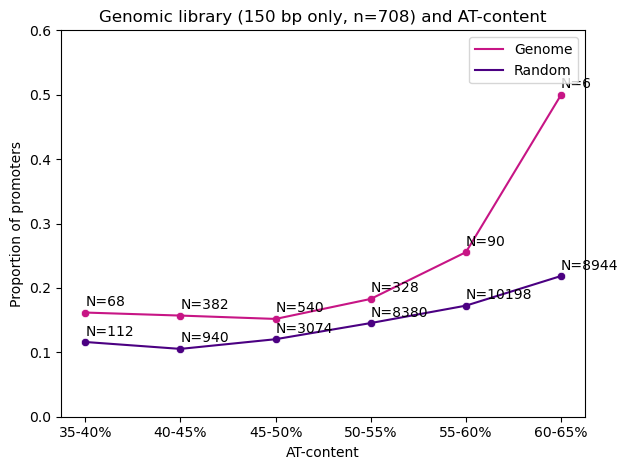

In [304]:
# Create a dataframe which only contains intergenic sequences
sub_df = genome_wt_df[genome_wt_df['length'] == 150]
print(len(sub_df))

cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(sub_df, color='mediumvioletred', label='Genome')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.6)
plt.title(f'Genomic library (150 bp only, n={len(sub_df)}) and AT-content')
plt.legend()
plt.tight_layout()

plt.savefig('Fig_S2D.pdf')

In [305]:
print(np.mean(genome_ratios))
print(np.mean(random_ratios))

0.23486116756421302
0.1463812346959586


### S2E
GFP reporter only

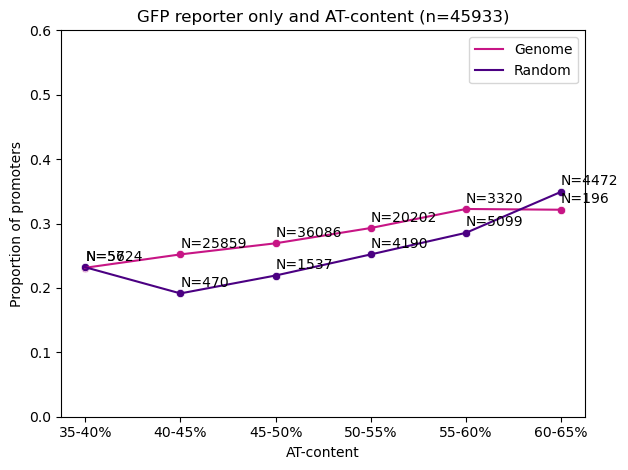

In [306]:
cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(genome_wt_df, color='mediumvioletred', label='Genome', fluorophore='GFP')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random', fluorophore='GFP')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.6)
plt.title(f'GFP reporter only and AT-content (n={int(len(genome_wt_df)/2)})')
plt.legend()
plt.tight_layout()

plt.savefig('Fig_S2E.pdf')

### S2F
RFP reporter only

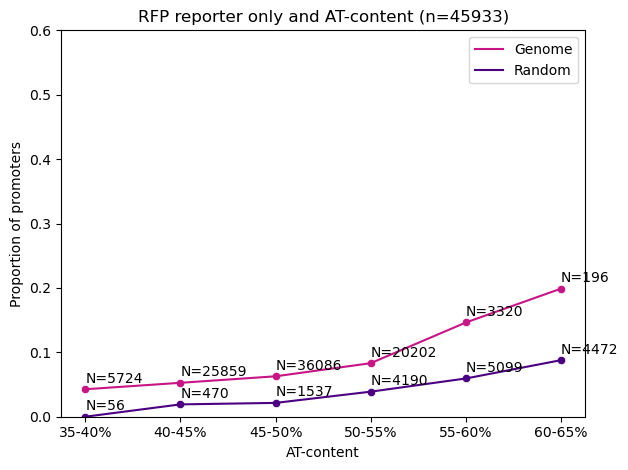

In [307]:
cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(genome_wt_df, color='mediumvioletred', label='Genome', fluorophore='RFP')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random', fluorophore='RFP')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.6)
plt.title(f'RFP reporter only and AT-content (n={int(len(genome_wt_df)/2)})')
plt.legend()
plt.tight_layout()

plt.savefig('Fig_S2F.pdf')

### S2G
top strand only

45772


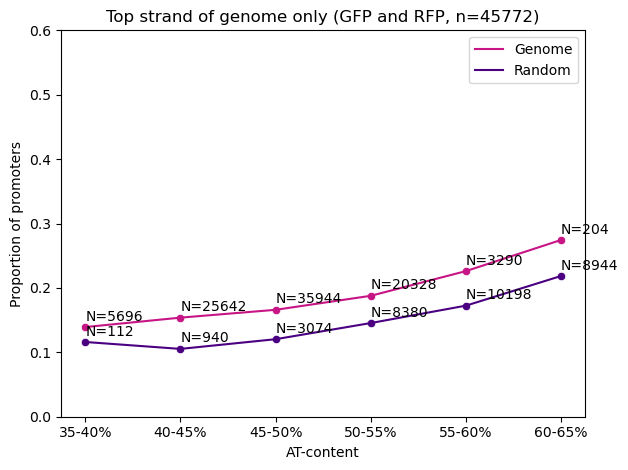

In [308]:
# Create a dataframe which only contains intergenic sequences
sub_df = genome_wt_df[genome_wt_df['strand'] == 'top']
print(len(sub_df))

cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(sub_df, color='mediumvioletred', label='Genome')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.6)
plt.title(f'Top strand of genome only (GFP and RFP, n={len(sub_df)})')
plt.legend()
plt.tight_layout()

plt.savefig('Fig_S2G.pdf')

### S2H
bottom strand only

46094


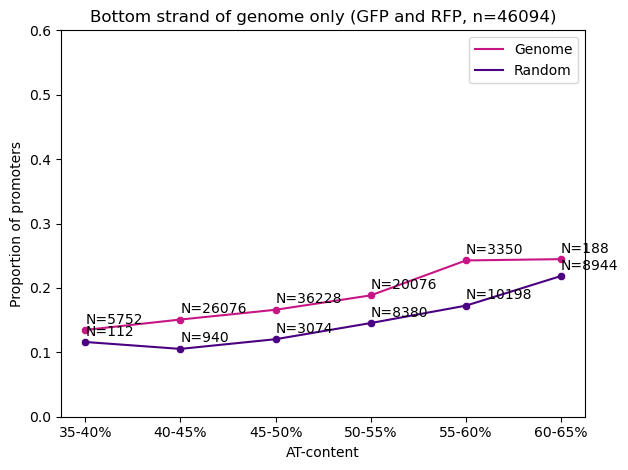

In [309]:
# Create a dataframe which only contains intergenic sequences
sub_df = genome_wt_df[genome_wt_df['strand'] == 'bottom']
print(len(sub_df))

cutoff = 1.5
bins = [(35, 40), (40, 45), (45, 50), (50, 55), (55, 60), (60, 65)]
bin_labels = [f"{low}-{high}%" for low, high in bins]

# Plot genome and random libraries
genome_ratios, ax = compute_ratios(sub_df, color='mediumvioletred', label='Genome')
random_ratios, ax = compute_ratios(random_wt_df, color='indigo', label='Random')
ax.set(xlabel='AT-content', ylabel='Proportion of promoters')
plt.ylim(0, 0.6)
plt.title(f'Bottom strand of genome only (GFP and RFP, n={len(sub_df)})')
plt.legend()
plt.tight_layout()

plt.savefig('Fig_S2H.pdf')

# Figure S3

### S3A
Mutational spectra

dict_keys([('T', 'A'), ('T', 'C'), ('T', 'G'), ('C', 'T'), ('A', 'T'), ('A', 'C'), ('A', 'G'), ('C', 'A'), ('C', 'G'), ('G', 'T'), ('G', 'A'), ('G', 'C')])
[7.811421063326428, 27.96585468564814, 1.518499209718395, 9.318794726306953, 7.954582024242658, 1.53688854316942, 26.15864294074865, 2.5334984695477236, 1.159815260756151, 2.703967590638726, 9.89677147667267, 1.4412640092240896]
[10.523298378587885, 33.84886199694236, 2.855504834090566, 6.14462436209384, 7.390290906741888, 1.601763527917142, 21.95123920673543, 2.837740358734739, 0.8370836114640081, 2.928177687818953, 8.079337223573997, 1.0020779052991968]
Power_divergenceResult(statistic=5.769449491147619, pvalue=0.8882957280336113)


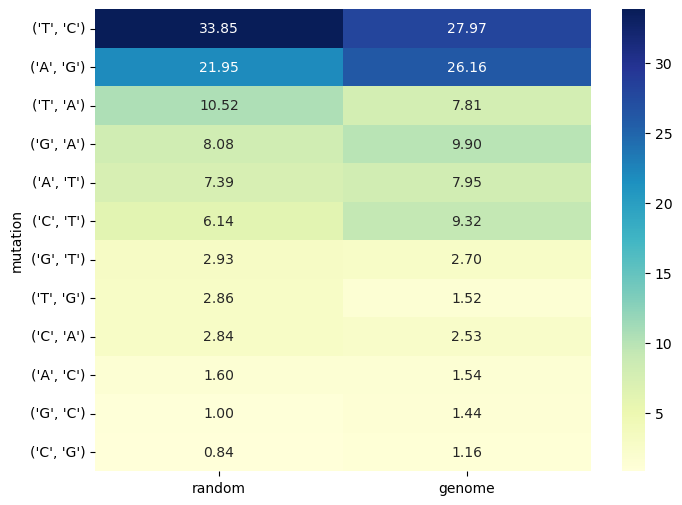

In [310]:
random_mutation_spectra = {}
random_parents = list(set(random_mut_df['parent'].to_list()))
for parent in random_parents:

    # Get the parent sequecne
    for record in SeqIO.parse('fasta/random_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    # Get the daughter sequences
    sub_df = random_mut_df[random_mut_df['parent'] == parent]
    daughters = sub_df['sequence'].to_list()

    # Loop along and find mutations
    for i in range(len(parent_seq)):
        for daughter in daughters:
            if daughter[i] == parent_seq[i]:
                pass
            else:
                before = parent_seq[i]
                after = daughter[i]

                if random_mutation_spectra.get((before, after)) is None:
                    random_mutation_spectra[(before, after)] = 1
                else:
                    random_mutation_spectra[(before, after)] +=1





genome_mutation_spectra = {}
genome_parents = list(set(genome_mut_df['parent'].to_list()))
for parent in genome_parents:

    # Get the parent sequecne
    for record in SeqIO.parse('fasta/genome_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    
    # Get the daughter sequences
    sub_df = genome_mut_df[genome_mut_df['parent'] == parent]
    daughters = sub_df['sequence'].to_list()

    # Loop along and find mutations
    for i in range(len(parent_seq)):
        for daughter in daughters:
            if daughter[i] == parent_seq[i]:
                pass
            else:
                before = parent_seq[i]
                after = daughter[i]

                if genome_mutation_spectra.get((before, after)) is None:
                    genome_mutation_spectra[(before, after)] = 1
                else:
                    genome_mutation_spectra[(before, after)] +=1

genome_percents = []
random_percents = []
for key in random_mutation_spectra.keys():
    random_percent = random_mutation_spectra[key]/sum(random_mutation_spectra.values())
    random_percents.append((100*random_percent))

    genome_percent = genome_mutation_spectra[key]/sum(genome_mutation_spectra.values())
    genome_percents.append((100*genome_percent))

print(random_mutation_spectra.keys())
print(genome_percents)
print(random_percents)

output = chisquare(random_percents, genome_percents)
print(output)



mutation_df = pd.DataFrame()
mutation_df['mutation'] = random_mutation_spectra.keys()
mutation_df['random'] = random_percents
mutation_df['genome'] = genome_percents
mutation_df = mutation_df.sort_values('random', ascending=False)
# Set 'mutation' as index (for heatmap labels)
mutation_df.set_index('mutation', inplace=True)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(mutation_df, annot=True, cmap='YlGnBu', cbar=True, fmt='.2f')

plt.savefig('Fig_S3A.pdf')

### S3B
Correlation plot

p_value: 3.849842668291451e-07
r: 0.9650919326105636


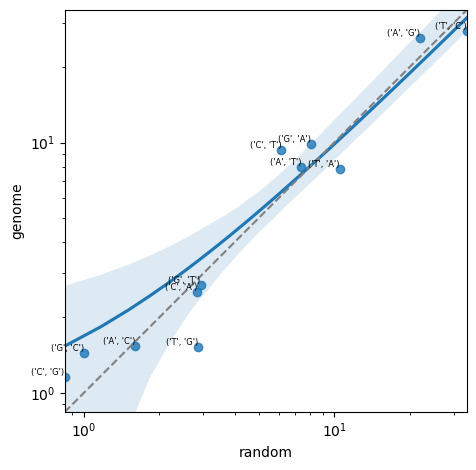

In [311]:
ax = sns.regplot(data=mutation_df, x='random', y='genome', label='mutation')
ax.set_xscale('log')
ax.set_yscale('log')

# Label each point using the index
for idx, row in mutation_df.iterrows():
    ax.text(row['random'], row['genome'], idx,
            fontsize=6, ha='right', va='bottom')

plt.tight_layout()

# Calculate Pearson correlation coefficient and p-value
r, p_value = pearsonr(mutation_df['random'], mutation_df['genome'])
print(f'p_value: {p_value}')
print(f'r: {r}')

# Add 1:1 line
lims = [
    np.min([mutation_df['random'].min(), mutation_df['genome'].min()]),
    np.max([mutation_df['random'].max(), mutation_df['genome'].max()])
]
ax.plot(lims, lims, ls='--', color='gray')  # dashed diagonal
ax.set_xlim(lims)
ax.set_ylim(lims)

# Force equal aspect ratio
ax.set_aspect('equal', adjustable='box')

plt.savefig('Fig_S3B.pdf')

### S3C
Daughters per parent

MannwhitneyuResult(statistic=7689.5, pvalue=0.097840395635783)


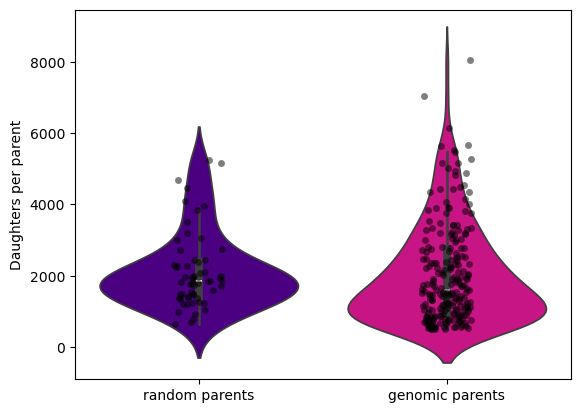

In [312]:
# Counts for each random parent
random_parents = random_mut_df['parent'].to_list()
random_counts = Counter(random_parents)
sorted_counts = sorted(random_counts.items(), key=lambda x: x[1], reverse=True)  # rank by count
parents, ran_counts = zip(*sorted_counts)

# Counts for each genomic parent
genome_parents = genome_mut_df['parent'].to_list()
genome_counts = Counter(genome_parents)
sorted_counts = sorted(genome_counts.items(), key=lambda x: x[1], reverse=True)  # rank by count
parents, gen_counts = zip(*sorted_counts)

# Plot
data = [ran_counts, gen_counts]
sns.violinplot(data=data)
plt.gca().collections[0].set_facecolor('indigo')
plt.gca().collections[1].set_facecolor('mediumvioletred')
sns.stripplot(data=data, color='black', alpha=0.5)
plt.ylabel('Daughters per parent')
plt.xticks([0, 1], ['random parents', 'genomic parents'])  # <-- fix: specify positions and labels

# MWU test
output = mannwhitneyu(data[0], data[1])
print(output)

plt.savefig("Fig_S3C.pdf")

### S3D
Point mutations per daughter

Counter({2: 255389, 3: 86477, 1: 58540, 4: 35992, 5: 13808, 6: 4937, 7: 1517, 8: 475, 9: 161, 10: 34})
Counter({2: 60553, 3: 16838, 1: 15494, 4: 12182, 5: 8689, 6: 6057, 7: 3709, 8: 2084, 9: 1129, 10: 508})


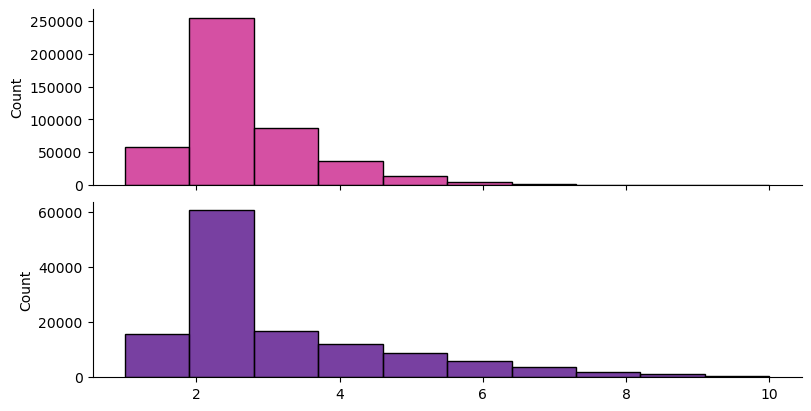

In [313]:
random_rates = []
genome_rates = []
### Random
for i, row in random_mut_df.iterrows():
    mutations = row['mutations']
    if mutations == 0:
        pass
    else:
        random_rates.append(mutations)

### Genome
for i, row in genome_mut_df.iterrows():
    mutations = row['mutations']
    if mutations == 0:
        pass
    else:
        genome_rates.append(mutations)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, sharey=False, sharex=True, figsize=(8, 4), constrained_layout=True)

sns.histplot(genome_rates, color='mediumvioletred', element='bars', bins=10, shrink=1.0, ax=axes[0])
sns.histplot(random_rates, color='indigo', element='bars', bins=10, shrink=1.0, ax=axes[1])

genome_counts = Counter(genome_rates)
print(genome_counts)

random_counts = Counter(random_rates)
print(random_counts)

# Optional: if you used sns.despine(), be sure not to remove bottom/left
sns.despine(top=True, right=True)  # keep bottom & left

plt.savefig('Fig_S3D.pdf')

### S3E
location of mutations

In [316]:
bases = ['A','T','C','G']

all_random_normalized_mutation_coordinates = []
random_parents = set(random_mut_df['parent'].to_list())

all_counts = []
for parent in random_parents:
    
    # Loop through daughters:
    sub_df = random_mut_df[random_mut_df['parent'] == parent]

    daughters = sub_df['sequence'].to_list()
    last_nucleotide = [n[0] for n in daughters]
    last_nucleotide_dict = Counter(last_nucleotide)
    
    #print(parent_seq[-1], last_nucleotide_dict)
    count = 0
    for base in bases:
        if base == parent_seq[0]:
            pass
        else:
            count +=last_nucleotide_dict[base]
    all_counts.append(count)

371528


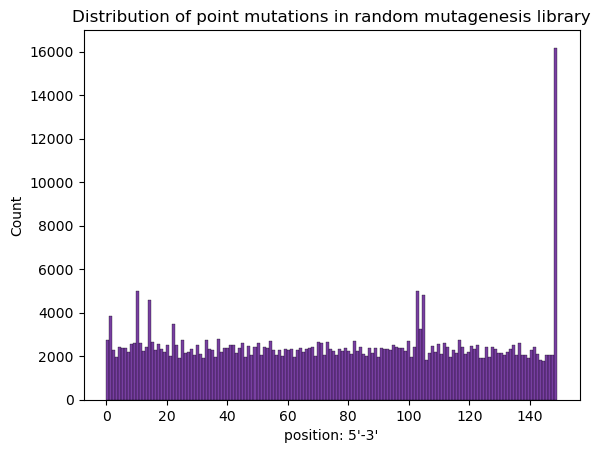

In [318]:
all_random_normalized_mutation_coordinates = []
random_parents = set(random_mut_df['parent'].to_list())
for parent in random_parents:
    
    # Get parent sequence
    for record in SeqIO.parse('fasta/random_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    # Loop through daughters:
    sub_df = random_mut_df[random_mut_df['parent'] == parent]

    daughters = sub_df['sequence'].to_list()
    last_nucleotide = [n[149] for n in daughters]
    #print(parent_seq[149], Counter(last_nucleotide))
    
    for i, row in sub_df.iterrows():
        daughter_seq = str(row['sequence'])

        # Loop through the length of each sequence
        mutation_coordinates = []
        for position, base in enumerate(parent_seq):
            if base == daughter_seq[position]:
                pass
            else:
                mutation_coordinates.append(position)

        # Normalize mutation_coordinates to the length as a percentage:
        normalized_mutation_coordinates = [n/len(parent_seq) for n in mutation_coordinates]

        # Add to master list
        all_random_normalized_mutation_coordinates += mutation_coordinates
        #all_random_normalized_mutation_coordinates += normalized_mutation_coordinates

print(len(all_random_normalized_mutation_coordinates))

sns.histplot(all_random_normalized_mutation_coordinates, color='indigo', bins=150)
plt.xlabel("position: 5'-3'")
plt.title('Distribution of point mutations in random mutagenesis library')
plt.savefig("Fig_S3E_top.pdf")

1087587


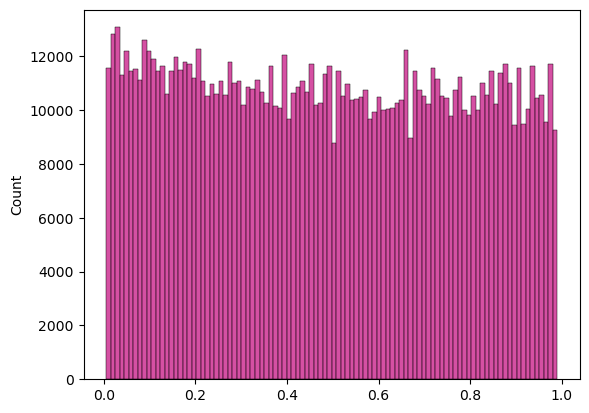

In [319]:
# Loop through each parent
all_genome_normalized_mutation_coordinates = []

genome_parents = set(genome_mut_df['parent'].to_list())
for parent in genome_parents:
    
    # Get parent sequence
    for record in SeqIO.parse('fasta/genome_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    # Loop through daughters:
    sub_df = genome_mut_df[genome_mut_df['parent'] == parent]
    for i, row in sub_df.iterrows():
        daughter_seq = row['sequence']

        # Loop through the length of each sequence
        mutation_coordinates = []
        for position, base in enumerate(parent_seq):
            if base == daughter_seq[position]:
                pass
            else:
                mutation_coordinates.append(position)

        # Normalize mutation_coordinates to the length as a percentage:
        normalized_mutation_coordinates = [n/len(parent_seq) for n in mutation_coordinates]

        # Add to master list
        all_genome_normalized_mutation_coordinates += normalized_mutation_coordinates

print(len(all_genome_normalized_mutation_coordinates))

# Plot
sns.histplot(all_genome_normalized_mutation_coordinates, color='mediumvioletred', bins=100)
plt.savefig('Fig_S3E_bottom.pdf')

# Figure S4

In [50]:
cutoff = 1.5

### S4A
Pnew vs number of point mutations

1
2
3
4
1
2
3
4
(array([ True,  True,  True,  True]), array([2.70831244e-15, 2.65846669e-16, 2.22518803e-16, 8.04468796e-11]), 0.012741455098566168, 0.0125)


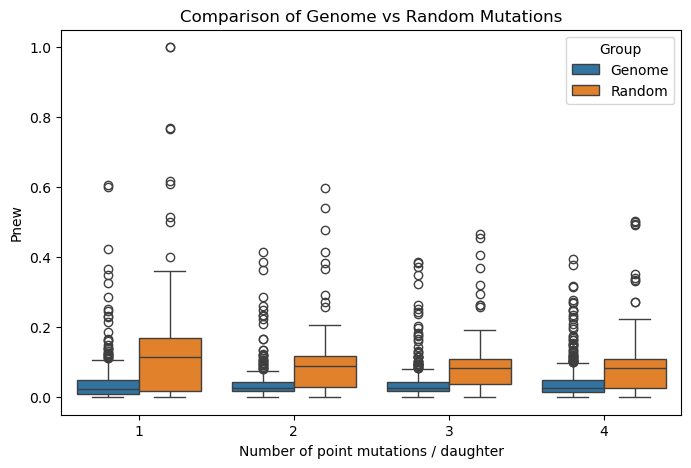

In [321]:
random_pnews_dict = {} # keys = number of point mutations: 1-10, values = list of pnews for all parents

random_parents = list(set(random_mut_df['parent'].to_list()))
for n in range(1,5):
    print(n)

    random_pnews_dict[n] = []
    
    for parent in random_parents:
        sub_df = random_mut_df[(random_mut_df['parent'] == parent) & (random_mut_df['mutations'] == n)]

        GFP_scores = sub_df['GFP_binary'].to_list()
        RFP_scores = sub_df['RFP_binary'].to_list()

        GFP_numerator = [n for n in GFP_scores if n >= cutoff]
        pnew_GFP = len(GFP_numerator)/len(GFP_scores)

        RFP_numerator = [n for n in RFP_scores if n >= cutoff]
        pnew_RFP = len(RFP_numerator)/len(RFP_scores)

        random_pnews_dict[n].append(pnew_GFP)
        random_pnews_dict[n].append(pnew_RFP)

genome_pnews_dict = {} # keys = number of point mutations: 1-10, values = list of pnews for all parents

genome_parents = list(set(genome_mut_df['parent'].to_list()))
for n in range(1,5):
    print(n)

    genome_pnews_dict[n] = []
    
    for parent in genome_parents:
        sub_df = genome_mut_df[(genome_mut_df['parent'] == parent) & (genome_mut_df['mutations'] == n)]

        GFP_scores = sub_df['GFP_binary'].to_list()
        RFP_scores = sub_df['RFP_binary'].to_list()

        GFP_numerator = [n for n in GFP_scores if n >= cutoff]
        pnew_GFP = len(GFP_numerator)/len(GFP_scores)

        RFP_numerator = [n for n in RFP_scores if n >= cutoff]
        pnew_RFP = len(RFP_numerator)/len(RFP_scores)

        genome_pnews_dict[n].append(pnew_GFP)
        genome_pnews_dict[n].append(pnew_RFP)

# Prepare the data in long format
mutation_counts = []
pnew_values = []
group_labels = []

for i in range(1, 5):  # Assuming mutations are 1-5
    mutation_counts += [i] * (len(genome_pnews_dict[i]) + len(random_pnews_dict[i]))
    pnew_values += genome_pnews_dict[i] + random_pnews_dict[i]
    group_labels += ["Genome"] * len(genome_pnews_dict[i]) + ["Random"] * len(random_pnews_dict[i])

# Convert to DataFrame
df = pd.DataFrame({"Mutations": mutation_counts, "Pnew": pnew_values, "Group": group_labels})

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Mutations", y="Pnew", hue="Group")
plt.xlabel(f'Number of point mutations / daughter')
plt.ylabel("Pnew")
plt.title("Comparison of Genome vs Random Mutations")
plt.savefig('Fig_S4A.pdf')

p_values = []
for i in range(1,5):
    output = mannwhitneyu(genome_pnews_dict[i], random_pnews_dict[i])
    #print(i, output)
    p_values.append(output[1])
#print(p_values)

# Benjamini-hochberg:
output = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
print(output)

### S4B
Pnew vs number of hotspots (this one takes a while...)

Equation: y = 0.031x + 0.061
Pearson correlation: 0.7504314901302663, p-value: 5.844709200112258e-23
Equation: y = 0.028x + 0.028
Pearson correlation: 0.717859117460081, p-value: 1.8226989379245168e-72


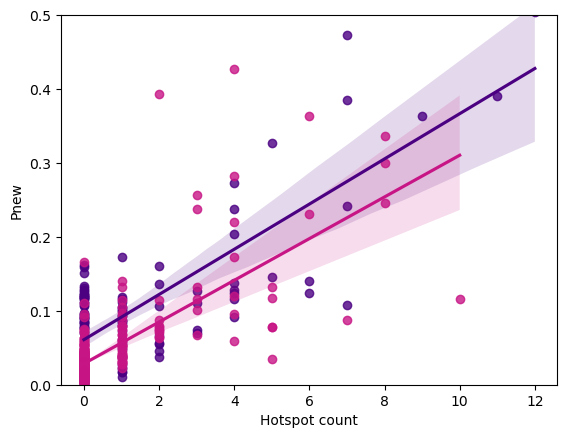

In [322]:
random_pnews = []
random_peaks = []

### Random parents
for parent in random_parents:

    # Calculate Pnew            
    sub_df = random_mut_df[random_mut_df['parent'] == parent]
    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()
    
    GFP_pnew = [n for n in GFP_scores if n >= cutoff]
    GFP_pnew = len(GFP_pnew)/len(GFP_scores)
    
    RFP_pnew = [n for n in RFP_scores if n >= cutoff]
    RFP_pnew = len(RFP_pnew)/len(RFP_scores)

    # Count number of mutual information hotspots:
    #parent = int(parent)
    GFP_means = calculate_mutual_information(parent, 'GFP', random_mut_df, 2)
    GFP_means = [max(x, 0) for x in GFP_means]
    GFP_peaks = len(find_peaks(GFP_means, 0.0025))
    #print(parent, GFP_pnew, peak_count)

    RFP_means = calculate_mutual_information(parent, 'RFP', random_mut_df, 2)
    RFP_means = [max(x, 0) for x in RFP_means]
    #RFP_peaks = len(find_peaks(RFP_means, np.percentile(RFP_means, 90)))
    RFP_peaks = len(find_peaks(RFP_means, 0.0025))
    #print(parent, GFP_pnew, peak_count)

    random_pnews.append(GFP_pnew)
    random_peaks.append(GFP_peaks)
    random_pnews.append(RFP_pnew)
    random_peaks.append(RFP_peaks)
    
sns.regplot(y=random_pnews, x=random_peaks, color='indigo')
plt.ylim(0,0.5)


slope, intercept, r_value, p_value, std_err = linregress(random_peaks, random_pnews)
print(f"Equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Pearson correlation: {r_value}, p-value: {p_value}")


### Genome parents
genome_pnews = []
genome_peaks = []

for parent in genome_parents:

    # Calculate Pnew            
    sub_df = genome_mut_df[genome_mut_df['parent'].astype(str) == parent]
    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()
    
    GFP_pnew = [n for n in GFP_scores if n >= cutoff]
    GFP_pnew = len(GFP_pnew)/len(GFP_scores)
    
    RFP_pnew = [n for n in RFP_scores if n >= cutoff]
    RFP_pnew = len(RFP_pnew)/len(RFP_scores)

    # Count number of mutual information hotspots
    GFP_means = calculate_mutual_information(parent, 'GFP', genome_mut_df, 2)
    GFP_means = [max(x, 0) for x in GFP_means]
    #GFP_peaks = len(find_peaks(GFP_means, np.percentile(GFP_means, 90)))
    GFP_peaks = len(find_peaks(GFP_means, 0.0025))
    #print(parent, GFP_pnew, peak_count)

    RFP_means = calculate_mutual_information(parent, 'RFP', genome_mut_df, 2)
    RFP_means = [max(x, 0) for x in RFP_means]
    #RFP_peaks = len(find_peaks(RFP_means, np.percentile(RFP_means, 90)))
    RFP_peaks = len(find_peaks(RFP_means, 0.0025))
    #print(parent, GFP_pnew, peak_count)

    genome_pnews.append(GFP_pnew)
    genome_peaks.append(GFP_peaks)
    genome_pnews.append(RFP_pnew)
    genome_peaks.append(RFP_peaks)
    
sns.regplot(y=genome_pnews, x=genome_peaks, color='mediumvioletred')
plt.ylim(0,0.5)
plt.ylabel('Pnew')
plt.xlabel('Hotspot count')

plt.savefig('Fig_S4B.pdf')

slope, intercept, r_value, p_value, std_err = linregress(genome_peaks, genome_pnews)
print(f"Equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Pearson correlation: {r_value}, p-value: {p_value}")

### S4C
Pnew vs AT-content correlation plots

p_value: 0.24121855673475073
r: 0.10779983676554022
Genomic:
Equation: y = 0.186x + -0.046
Pearson correlation: 0.17191326301356039, p-value: 0.000248305039789123


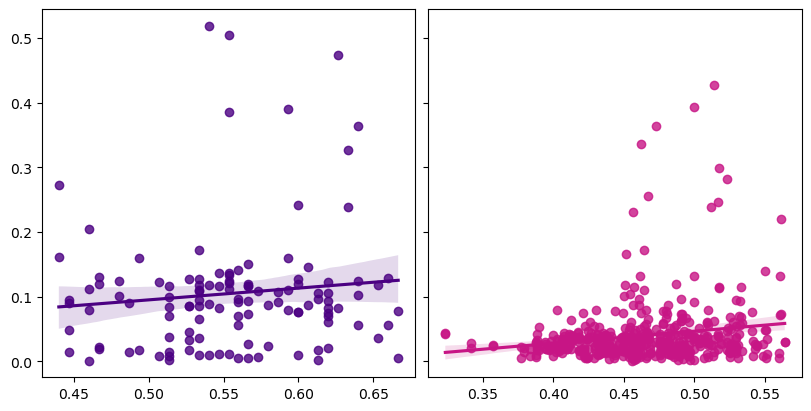

In [54]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4), constrained_layout=True)

random_AT_contents = []
random_pnews = []

random_parents = list(set(random_mut_df['parent'].to_list()))
for parent in random_parents:
    #print(parent)

    # Calculate pnews
    sub_df = random_mut_df[random_mut_df['parent'] == parent]

    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()

    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    pnew_GFP = len(GFP_numerator)/len(GFP_scores)

    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    pnew_RFP = len(RFP_numerator)/len(RFP_scores)

    random_pnews.append(pnew_GFP)
    random_pnews.append(pnew_RFP)

    # Calculate AT-content for parent sequences
    for record in SeqIO.parse('fasta/random_parents.fasta', 'fasta'):
        #print(str(record.id))
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    random_AT_contents.append(1-gc_fraction(parent_seq))
    random_AT_contents.append(1-gc_fraction(parent_seq))

sns.regplot(x=random_AT_contents, y=random_pnews, ax=axes[0], color='indigo')

# Calculate Pearson correlation coefficient and p-value
r, p_value = pearsonr(random_AT_contents, random_pnews)
print(f'p_value: {p_value}')
print(f'r: {r}')

genome_AT_contents = []
genome_pnews = []

genome_parents = list(set(genome_mut_df['parent'].to_list()))
for parent in genome_parents:

    # Calculate pnews
    sub_df = genome_mut_df[genome_mut_df['parent'] == parent]

    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()

    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    pnew_GFP = len(GFP_numerator)/len(GFP_scores)

    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    pnew_RFP = len(RFP_numerator)/len(RFP_scores)

    genome_pnews.append(pnew_GFP)
    genome_pnews.append(pnew_RFP)

    # Calculate AT-content for parent sequences
    for record in SeqIO.parse('fasta/genome_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    genome_AT_contents.append(1-gc_fraction(parent_seq))
    genome_AT_contents.append(1-gc_fraction(parent_seq))

sns.regplot(x=genome_AT_contents, y=genome_pnews, color='mediumvioletred')

### Line of best fit and linear regression for random parents
slope, intercept, r_value, p_value, std_err = linregress(genome_AT_contents, genome_pnews)
print('Genomic:')
print(f"Equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Pearson correlation: {r_value}, p-value: {p_value}")

plt.savefig('Fig_S4C.pdf')

### S4D
Pnew vs AT-content

(array([ True,  True]), array([4.00734305e-04, 1.99984434e-08]), 0.025320565519103666, 0.025)


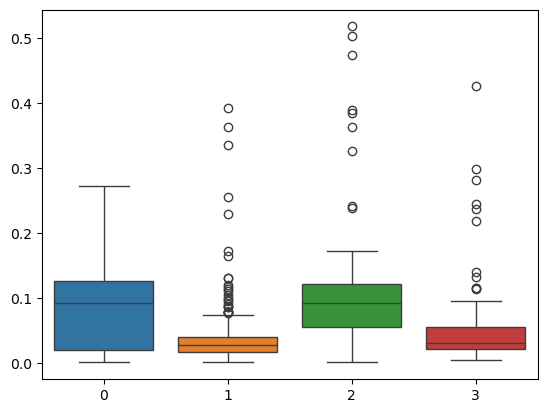

In [324]:
random_less_50 = []
random_greater_50 = []

random_parents = list(set(random_mut_df['parent'].to_list()))
for parent in random_parents:

    # Calculate pnews
    sub_df = random_mut_df[random_mut_df['parent'] == parent]

    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()

    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    pnew_GFP = len(GFP_numerator)/len(GFP_scores)

    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    pnew_RFP = len(RFP_numerator)/len(RFP_scores)

    # Calculate AT-content for parent sequences
    for record in SeqIO.parse('fasta/random_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    AT_content = 1-gc_fraction(parent_seq)
    if AT_content <= 0.5:
        random_less_50.append(pnew_GFP)
        random_less_50.append(pnew_RFP)
    else:
        random_greater_50.append(pnew_GFP)
        random_greater_50.append(pnew_RFP)



genome_less_50 = []
genome_greater_50 = []

genome_parents = list(set(genome_mut_df['parent'].to_list()))
for parent in genome_parents:

    # Calculate pnews
    sub_df = genome_mut_df[genome_mut_df['parent'] == parent]

    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()

    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    pnew_GFP = len(GFP_numerator)/len(GFP_scores)

    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    pnew_RFP = len(RFP_numerator)/len(RFP_scores)

    # Calculate AT-content for parent sequences
    for record in SeqIO.parse('fasta/genome_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    AT_content = 1-gc_fraction(parent_seq)
    if AT_content <= 0.5:
        genome_less_50.append(pnew_GFP)
        genome_less_50.append(pnew_RFP)
    else:
        genome_greater_50.append(pnew_GFP)
        genome_greater_50.append(pnew_RFP)



data = [random_less_50, genome_less_50, random_greater_50, genome_greater_50]
sns.boxplot(data=data)
plt.savefig('Fig_S4D.pdf')

p_values = []

# Random vs genomic below 50% AT-content
output = mannwhitneyu(random_less_50, genome_less_50)
p_values.append(output[1])

# Random vs genomic above 50% At-content
output = mannwhitneyu(random_greater_50, genome_greater_50)
p_values.append(output[1])

# Benjamini-hochberg:
output = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
print(output)

### S4E
Pnew vs number of daughter sequences

p_value: 0.9807727659900372
r: 0.0022232963416858606
p_value: 0.41161783835835647
r: 0.03879799980513154


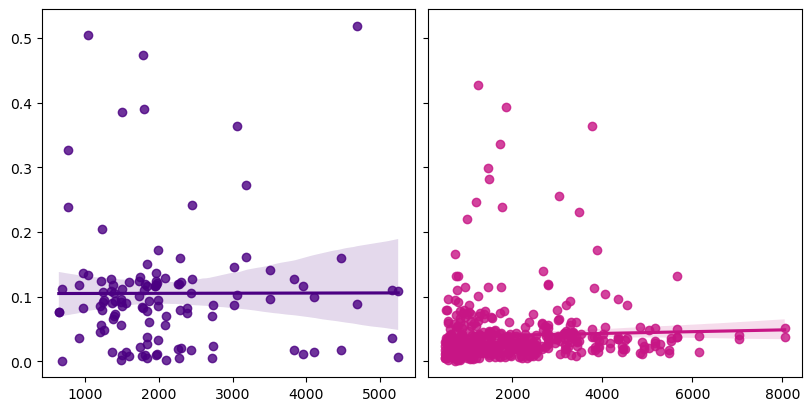

In [102]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4), constrained_layout=True)

random_daughters = []
random_pnews = []

random_parents = list(set(random_mut_df['parent'].to_list()))
for parent in random_parents:

    # Calculate pnews
    sub_df = random_mut_df[random_mut_df['parent'] == parent]

    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()

    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    pnew_GFP = len(GFP_numerator)/len(GFP_scores)

    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    pnew_RFP = len(RFP_numerator)/len(RFP_scores)

    random_pnews.append(pnew_GFP)
    random_pnews.append(pnew_RFP)

    random_daughters.append(len(sub_df))
    random_daughters.append(len(sub_df))

sns.regplot(x=random_daughters, y=random_pnews, ax=axes[0], color='indigo')

# Calculate Pearson correlation coefficient and p-value
r, p_value = pearsonr(random_daughters, random_pnews)
print(f'p_value: {p_value}')
print(f'r: {r}')

genome_daughters = []
genome_pnews = []

genome_parents = list(set(genome_mut_df['parent'].to_list()))
for parent in genome_parents:

    # Calculate pnews
    sub_df = genome_mut_df[genome_mut_df['parent'] == parent]

    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()

    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    pnew_GFP = len(GFP_numerator)/len(GFP_scores)

    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    pnew_RFP = len(RFP_numerator)/len(RFP_scores)

    genome_pnews.append(pnew_GFP)
    genome_pnews.append(pnew_RFP)

    genome_daughters.append(len(sub_df))
    genome_daughters.append(len(sub_df))

sns.regplot(x=genome_daughters, y=genome_pnews, color='mediumvioletred')

# Calculate Pearson correlation coefficient and p-value
r, p_value = pearsonr(genome_daughters, genome_pnews)
print(f'p_value: {p_value}')
print(f'r: {r}')

plt.savefig('Fig_S4E.pdf')

### S4F
Pnew vs length of genome parent

p_value: 0.10407540390767045
r: -0.0767229420531036


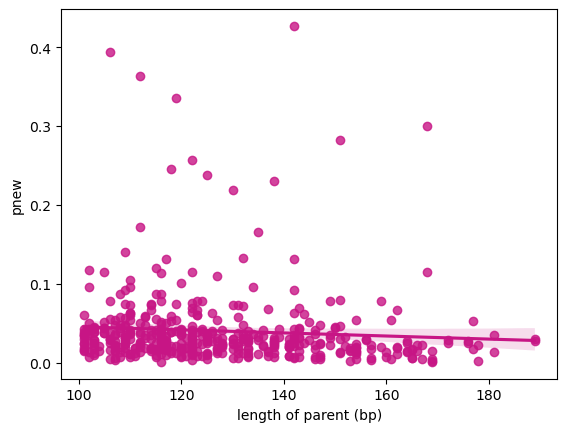

In [326]:
lengths = []
pnews = []

genome_parents = list(set(genome_mut_df['parent'].to_list()))
for parent in genome_parents:

    # Calculate pnews
    sub_df = genome_mut_df[genome_mut_df['parent'] == parent]

    GFP_scores = sub_df['GFP_binary'].to_list()
    RFP_scores = sub_df['RFP_binary'].to_list()

    GFP_numerator = [n for n in GFP_scores if n >= cutoff]
    pnew_GFP = len(GFP_numerator)/len(GFP_scores)

    RFP_numerator = [n for n in RFP_scores if n >= cutoff]
    pnew_RFP = len(RFP_numerator)/len(RFP_scores)

    # Calculate AT-content for parent sequences
    for record in SeqIO.parse('fasta/genome_parents.fasta', 'fasta'):
        if str(record.id) == str(parent):
            parent_seq = str(record.seq)

    # Append
    lengths.append(len(parent_seq))
    lengths.append(len(parent_seq))
    pnews.append(pnew_GFP)
    pnews.append(pnew_RFP)

sns.regplot(x=lengths, y=pnews, color='mediumvioletred')
# Calculate Pearson correlation coefficient and p-value
r, p_value = pearsonr(lengths, pnews)
print(f'p_value: {p_value}')
print(f'r: {r}')

plt.ylabel('pnew')
plt.xlabel('length of parent (bp)')

plt.savefig('Fig_S4F.pdf')

# Figure S5

### S5A
random ridgeplots

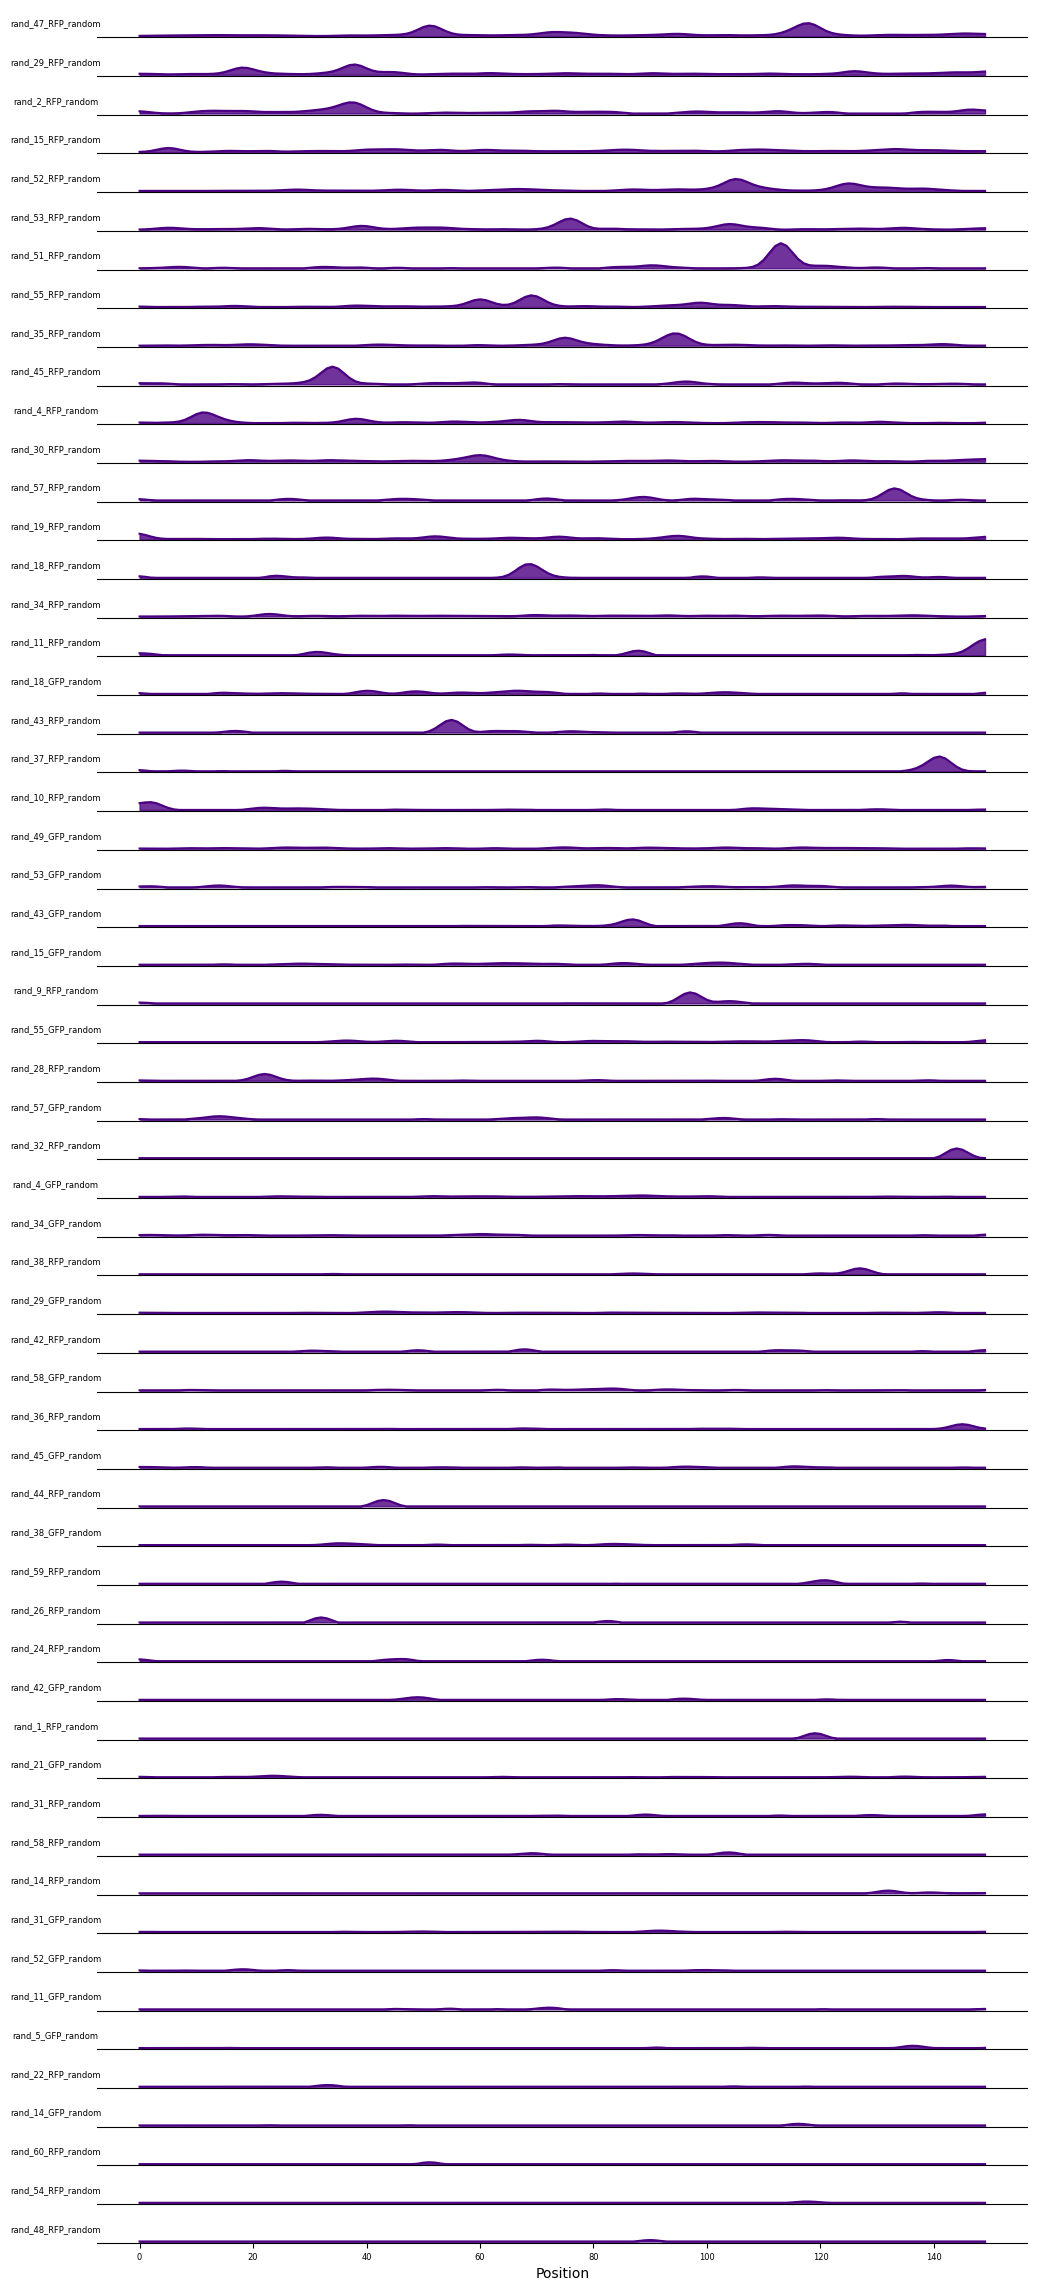

In [327]:
fluors = ['GFP', 'RFP']
min_height = 0.0025

# Store plot data as (means, label, color)
all_plot_data = []
for parent in random_parents:
    #print(parent)
    for Fluor in fluors:
        means = calculate_mutual_information(parent, Fluor, random_mut_df, 2)
        means = [max(x, 0) for x in means]
        peak_indices = find_peaks(means, min_height)

        # Only show those with at least 1 hotspot
        if len(peak_indices) > 0:
            label = f'{parent}_{Fluor}_random'
            all_plot_data.append((means, label, 'indigo'))

# After collecting all_plot_data
all_plot_data.sort(key=lambda x: sum(x[0]), reverse=True)

n_plots = len(all_plot_data)
fig_height = n_plots * 0.5
fig = plt.figure(figsize=(12, fig_height))
#gs = gridspec.GridSpec(n_plots, 1, hspace=-0.7)
gs = gridspec.GridSpec(n_plots, 1, hspace=0.4)

ax_first = None

for idx, (means, label, color) in enumerate(all_plot_data):
    if idx == 0:
        ax = fig.add_subplot(gs[idx, 0])
        ax_first = ax
    else:
        ax = fig.add_subplot(gs[idx, 0], sharey=ax_first)  # share y-axis

    x = range(len(means))
    ax.plot(x, means, color=color)
    ax.fill_between(x, means, color=color, alpha=0.8)

    ax.set_ylabel(label, fontsize=6, rotation=0, labelpad=30, va='center')

    ax.set_yticks([])
    ax.tick_params(labelsize=6)
    sns.despine(ax=ax, top=True, right=True, left=True)

    if idx != n_plots - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel("Position")

plt.savefig('Fig_S5A.pdf', bbox_inches='tight')

### S5B
genomic ridgeplots

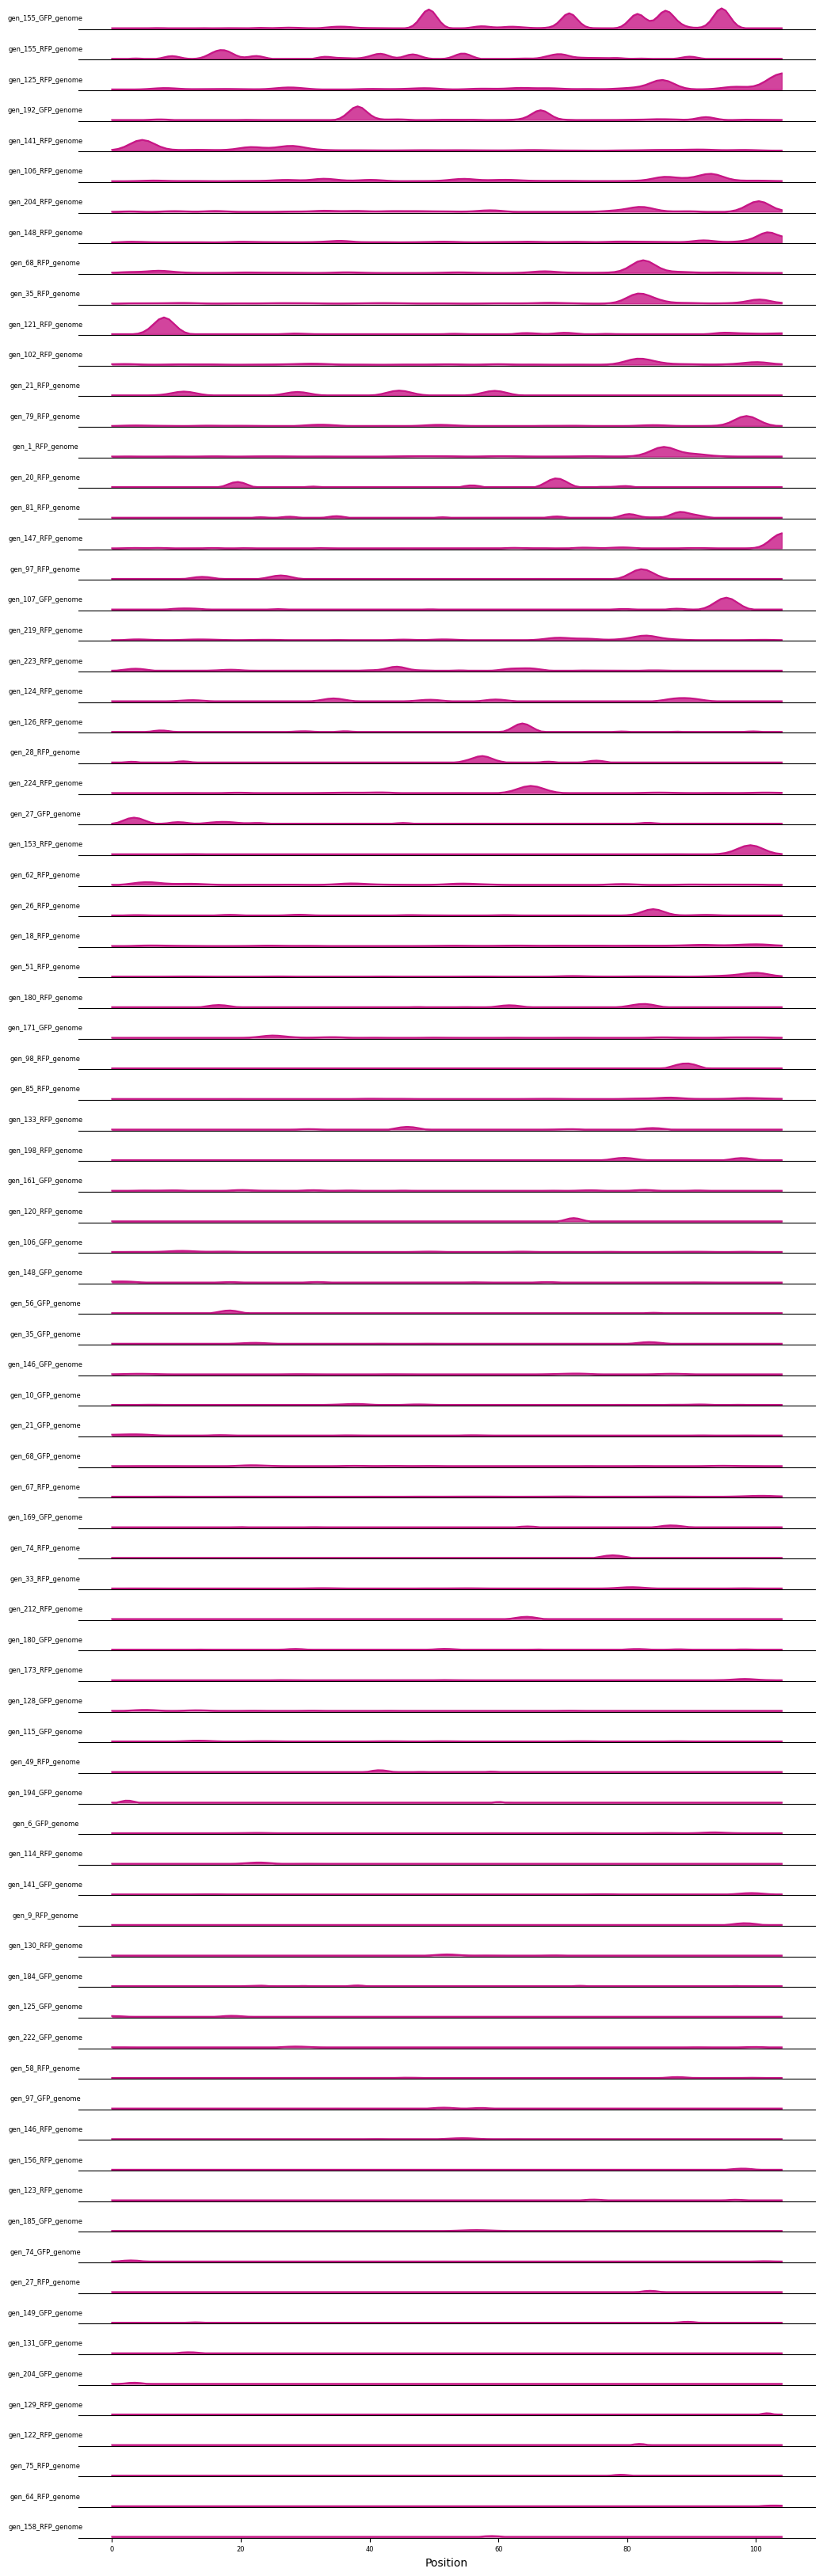

In [328]:
fluors = ['GFP', 'RFP']
min_height = 0.0025

# Store plot data as (means, label, color)
all_plot_data = []
for parent in genome_parents:
    for Fluor in fluors:
        means = calculate_mutual_information(parent, Fluor, genome_mut_df, 2)
        means = [max(x, 0) for x in means]
        peak_indices = find_peaks(means, min_height)

        if len(peak_indices) > 0:
            label = f'{parent}_{Fluor}_genome'
            all_plot_data.append((means, label, 'mediumvioletred'))

# After collecting all_plot_data
all_plot_data.sort(key=lambda x: sum(x[0]), reverse=True)

n_plots = len(all_plot_data)
fig_height = n_plots * 0.5
fig = plt.figure(figsize=(12, fig_height))
gs = gridspec.GridSpec(n_plots, 1, hspace=0.4)

ax_first = None

for idx, (means, label, color) in enumerate(all_plot_data):
    if idx == 0:
        ax = fig.add_subplot(gs[idx, 0])
        ax_first = ax
    else:
        ax = fig.add_subplot(gs[idx, 0], sharey=ax_first)  # share y-axis

    x = range(len(means))
    ax.plot(x, means, color=color)
    ax.fill_between(x, means, color=color, alpha=0.8)

    ax.set_ylabel(label, fontsize=6, rotation=0, labelpad=30, va='center')

    ax.set_yticks([])
    ax.tick_params(labelsize=6)
    sns.despine(ax=ax, top=True, right=True, left=True)

    if idx != n_plots - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel("Position")

plt.savefig('Fig_S5B.pdf', bbox_inches='tight')

# Figure S6

0 0
0 1
0 2
0 3
0.0025 0
0.0025 1
0.0025 2
0.0025 3
0.005 0
0.005 1
0.005 2
0.005 3
0.025 0
0.025 1
0.025 2
0.025 3


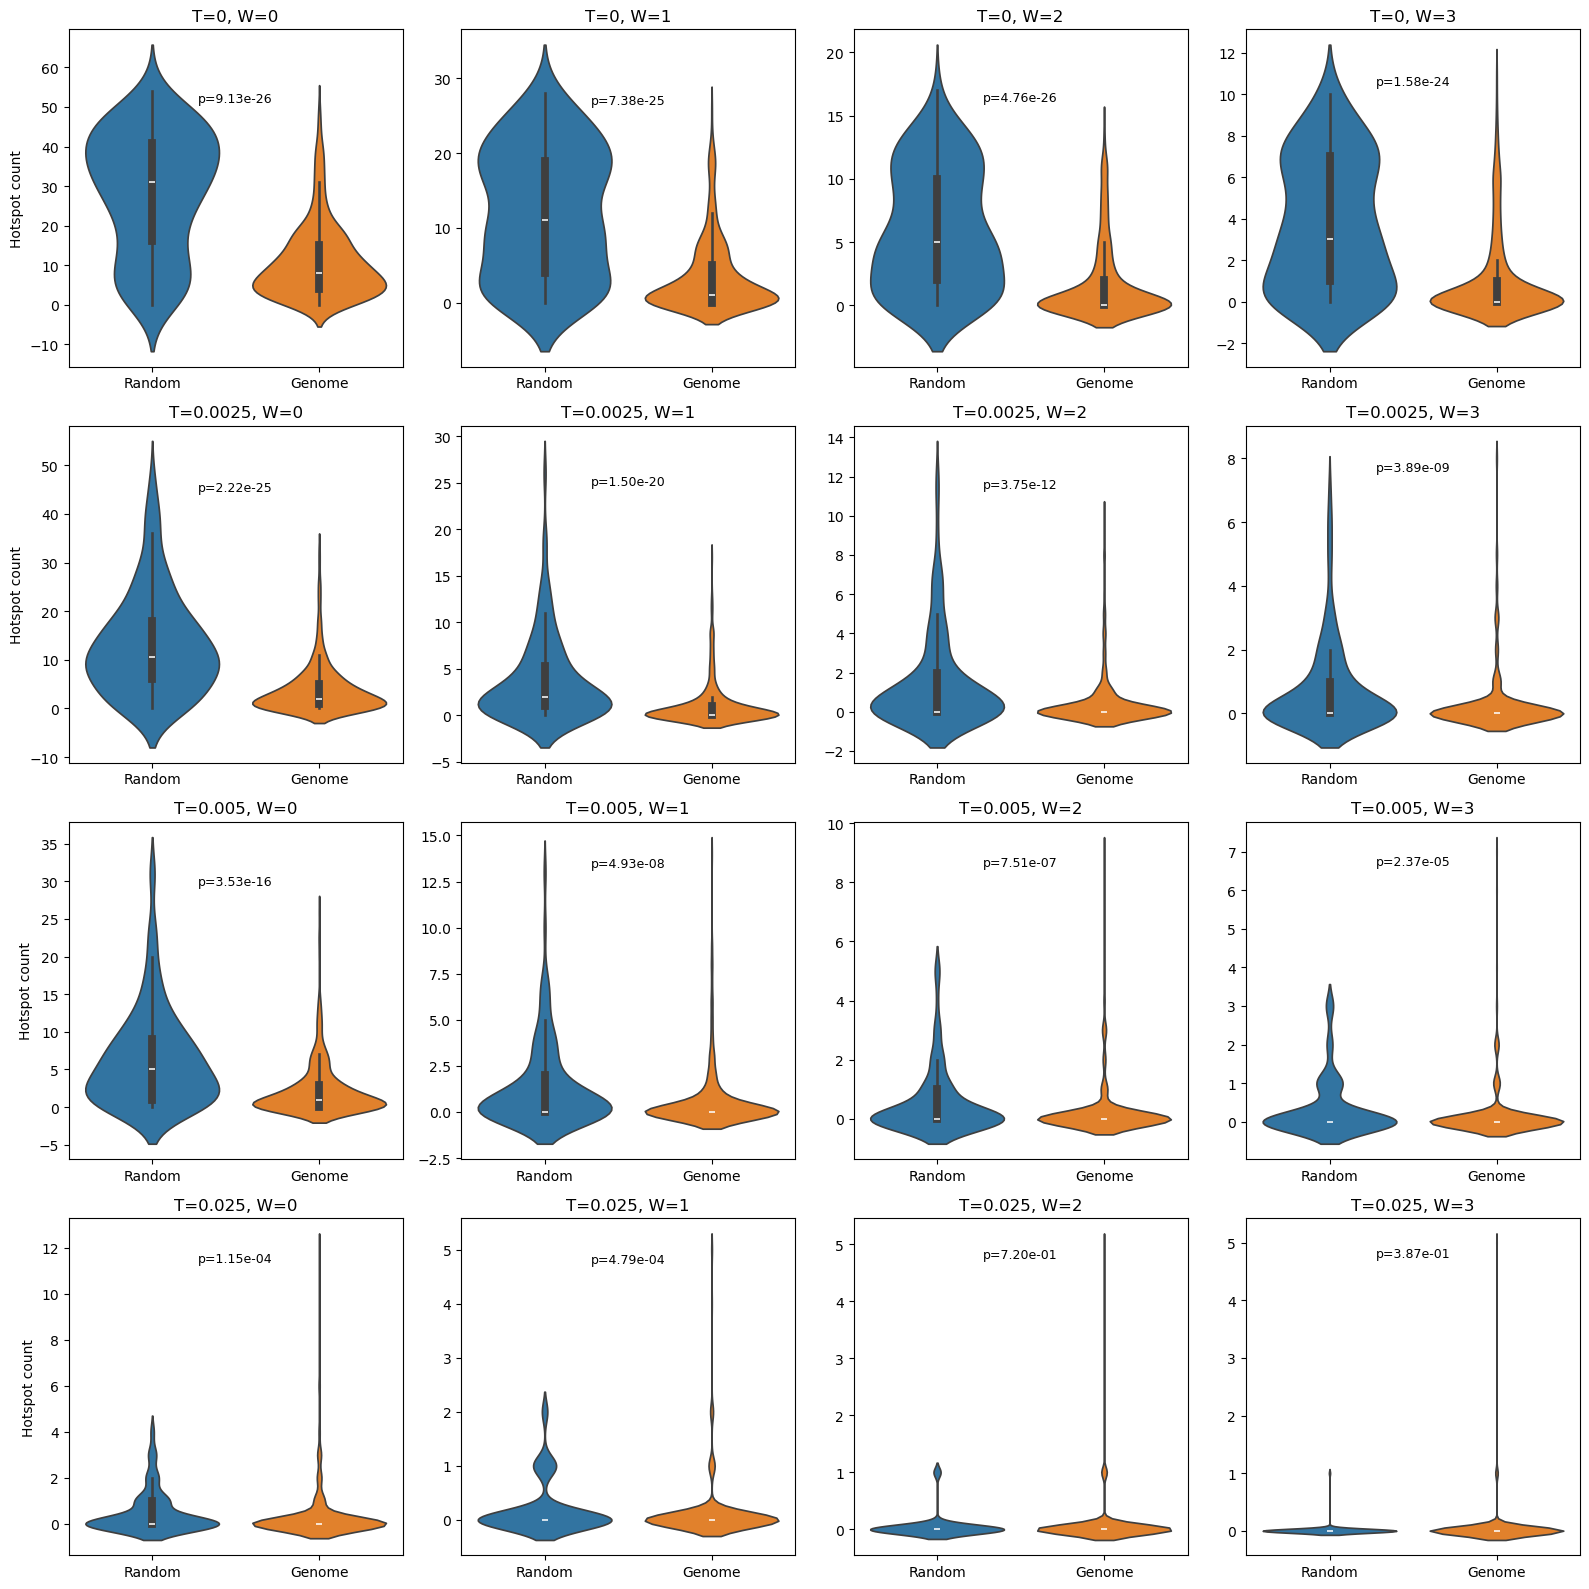

In [230]:
# Define parameters
fluors = ['GFP', 'RFP']
thresholds = [0, 0.0025, 0.005, 0.025]
smoothing_vals = [0, 1, 2, 3]

# thresholds = [0.0025]
# smoothing_vals = [1,2]

# Create figure
fig, axes = plt.subplots(len(thresholds), len(smoothing_vals), figsize=(16, 16), sharey=False)
axes = axes.flatten() #<-- uncomment if looking at more than one example

p_values = []
# Loop over parameter combinations
for idx, (threshold, smoothing) in enumerate(itertools.product(thresholds, smoothing_vals)):
    print(threshold, smoothing)
    
    random_peak_counts = []
    genome_peak_counts = []

    # Random parents
    for parent in random_parents:
        for Fluor in fluors:
            means = calculate_mutual_information(parent, Fluor, random_mut_df, smoothing)
            means = [max(x, 0) for x in means]
            peak_indices = find_peaks(means, min_height=threshold)
            random_peak_counts.append(len(peak_indices))

    # Genome parents
    for parent in genome_parents:
        for Fluor in fluors:
            means = calculate_mutual_information(parent, Fluor, genome_mut_df, smoothing)
            means = [max(x, 0) for x in means]
            peak_indices = find_peaks(means, min_height=threshold)
            genome_peak_counts.append(len(peak_indices))

    # Plot
    ax = axes[idx]  # Use this to get the current subplot
    data = [random_peak_counts, genome_peak_counts]
    sns.violinplot(data=data, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Random", "Genome"])
    ax.set_ylabel('Hotspot count' if idx % 4 == 0 else "")
    ax.set_title(f"T={threshold}, W={smoothing}")
    
    u_statistic, p_value = mannwhitneyu(data[0], data[1])
    p_values.append(p_value)
    ax.text(0.5, max(max(data[0]), max(data[1])) * 0.95,
            f"p={p_value:.2e}", ha='center', fontsize=9)

    sub_df = pd.DataFrame(data)
    sub_df[0] = ['random', 'genomic']
    sub_df.to_csv(f"threshold_{threshold}_smoothing_{smoothing}.csv", index=False)

plt.tight_layout()
#plt.savefig("Fig_S6.pdf")

In [398]:
# Benjamini-hochberg:
output = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
print(output)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False]), array([7.30400000e-25, 2.95200000e-24, 7.30400000e-25, 5.05600000e-24,
       1.18400000e-24, 4.00000000e-20, 7.50000000e-12, 6.91555556e-09,
       8.06857143e-16, 7.88800000e-08, 1.09236364e-06, 3.16000000e-05,
       1.41538462e-04, 5.47428571e-04, 7.20000000e-01, 4.12800000e-01]), 0.0032006977101884937, 0.003125)


# Figure S7

In [57]:
if 'sub_random_output' not in locals():
    print('please run cell Fig 3C before proceeding...')
if 'sub_genome_output' not in locals():
    print('please run cell Fig 3C before proceeding...')

### S7A
sigma70 -10 box

<Figure size 600x300 with 0 Axes>

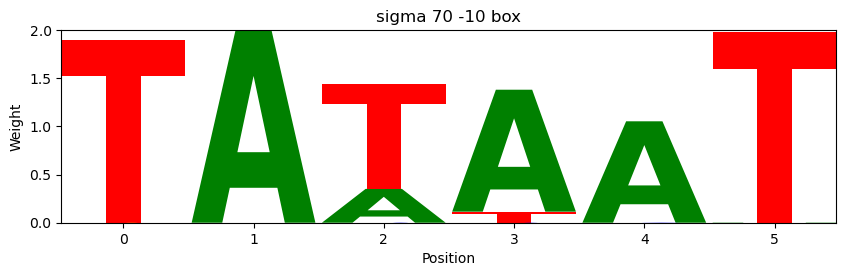

In [330]:
pwm = pd.DataFrame(PSSMs_dict['minus10'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S7A.pdf')

### S7B
Random parent #55 gains a σ70 -10 box

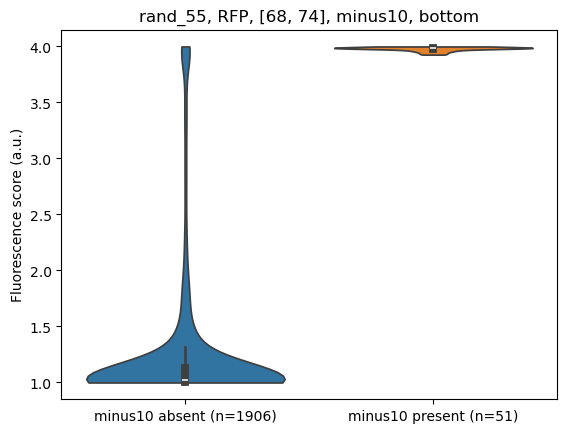

In [58]:
### KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_55'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [68, 74] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'minus10' #string: 'minus10' or 'minus35'

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
#plt.savefig(f'random_{parent}_{fluor}_{orientation}_{ROI}_{TF}.pdf')
plt.savefig('Fig_S7B.pdf')

In [60]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor      PWM       P-value       ROI  N_without  \
2411      bottom  rand_55   RFP  minus10  7.834559e-35  [68, 74]       1906   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
2411      51         1.0258    3.985002  1.690959e-32    True      gain   

      fluorescence_change  
2411             2.959202

### S7C
Genomic parent #27 gains a σ70 -10 box

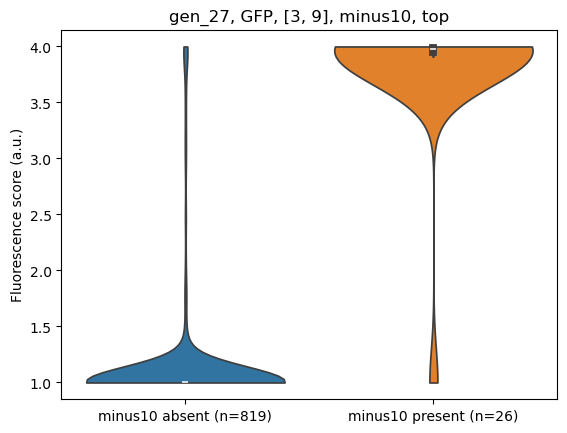

In [61]:
### KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_27'
fluor = 'GFP' #string: 'RFP' or 'GFP'
ROI = [3, 9] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'minus10' #string: 'minus10' or 'minus35'

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
plt.savefig('Fig_S7C.pdf')

In [62]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation  Parent Fluor      PWM       P-value     ROI  N_without  \
1238         top  gen_27   GFP  minus10  2.748792e-26  [3, 9]        819   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
1238      26            1.0    3.976361  3.861917e-25    True      gain   

      fluorescence_change  
1238             2.976361

### S7D
σ70 -35 box

<Figure size 600x300 with 0 Axes>

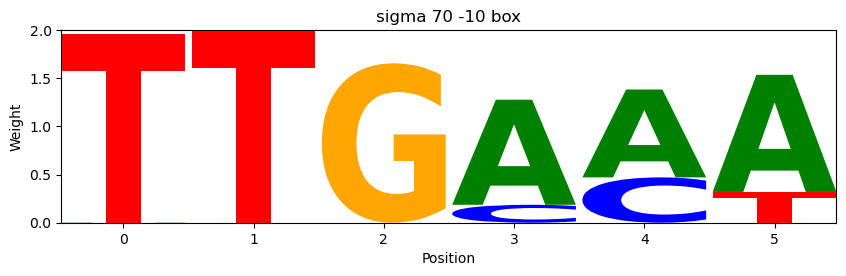

In [336]:
pwm = pd.DataFrame(PSSMs_dict['minus35'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S7D.pdf')

### S7E 
random parent #10 gains a σ70 -35 box

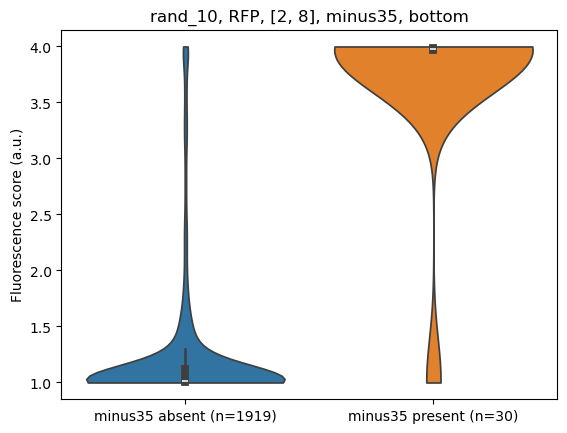

In [63]:
### KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_10'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [2, 8] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'minus35' #string: 'minus10' or 'minus35'

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
plt.savefig('Fig_S7E.pdf')

In [64]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor      PWM       P-value     ROI  N_without  \
1951      bottom  rand_10   RFP  minus35  1.173794e-19  [2, 8]       1919   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
1951      30       1.009868    3.981496  5.629863e-18    True      gain   

      fluorescence_change  
1951             2.971628

### S7F
Genomic parent #141 gains a σ70 -35 box

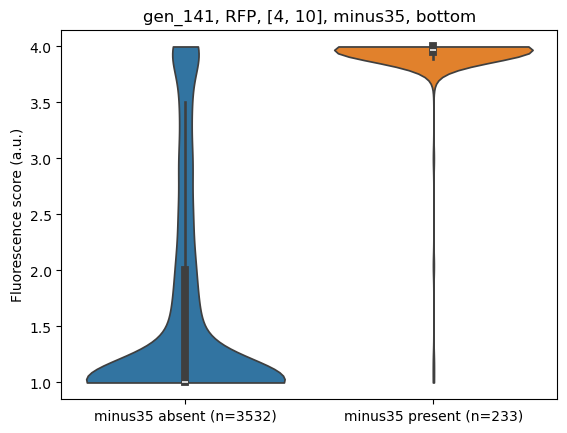

In [65]:
### KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_141'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [4, 10] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'minus35' #string: 'minus10' or 'minus35'

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
plt.savefig('Fig_S7F.pdf')

In [66]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor      PWM        P-value      ROI  N_without  \
1222      bottom  gen_141   RFP  minus35  1.544335e-133  [4, 10]       3532   

      N_with  Fluor_without  Fluor_with        Q-value  status gain-loss  \
1222     233            1.0    3.970047  1.826176e-131    True      gain   

      fluorescence_change  
1222             2.970047

### S7G
σH -10 box

<Figure size 600x300 with 0 Axes>

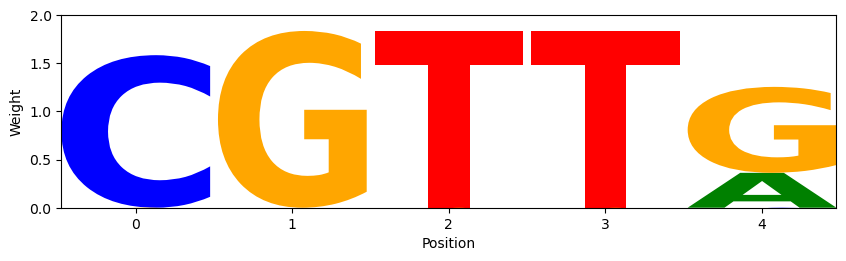

In [339]:
pwm = pd.DataFrame(PSSMs_dict['sigH_10'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S7G.pdf')

### S7H
Random parent #32 gains a σH -10 box

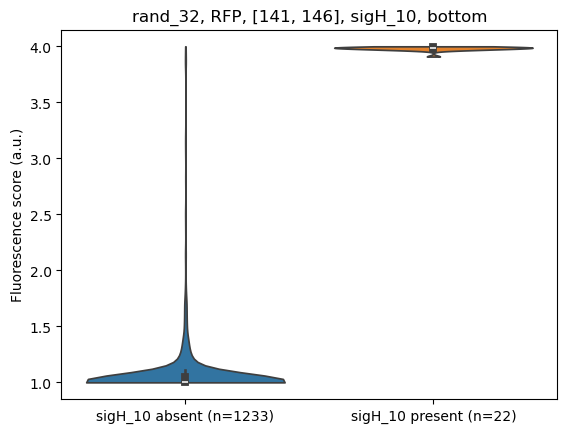

In [67]:
### KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_32'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [141, 146] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'sigH_10' #string

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
plt.savefig('Fig_S7H.pdf')

In [68]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor      PWM       P-value         ROI  N_without  \
2142      bottom  rand_32   RFP  sigH_10  1.276315e-18  [141, 146]       1233   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
2142      22            1.0    3.986886  5.085624e-17    True      gain   

      fluorescence_change  
2142             2.986886

### S7I
Genomic parent #148 gains a σH -10 box

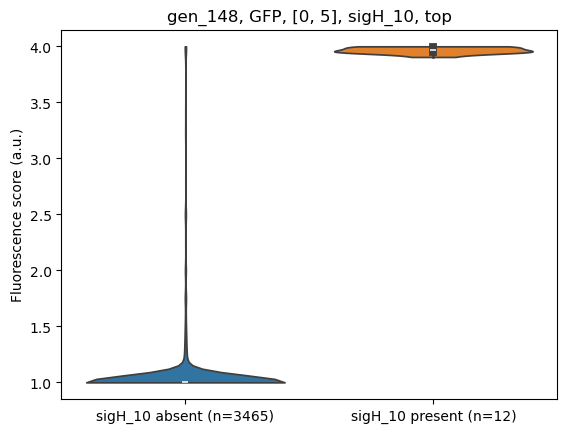

In [69]:
## KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_148'
fluor = 'GFP' #string: 'RFP' or 'GFP'
ROI = [0, 5] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'sigH_10' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S7I.pdf')

In [70]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor      PWM       P-value     ROI  N_without  \
992         top  gen_148   GFP  sigH_10  1.558098e-25  [0, 5]       3465   

     N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
992      12            1.0    3.963315  2.085793e-24    True      gain   

     fluorescence_change  
992             2.963315

### S7J
σH -35 box

<Figure size 600x300 with 0 Axes>

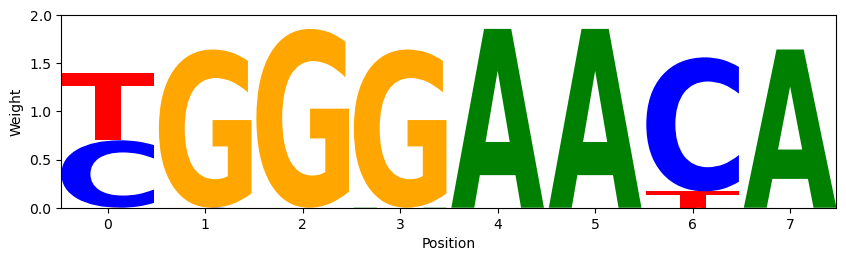

In [342]:
pwm = pd.DataFrame(PSSMs_dict['sigH_35'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S7J.pdf')

### S7K
Random parent #51 gains a σH -35 box

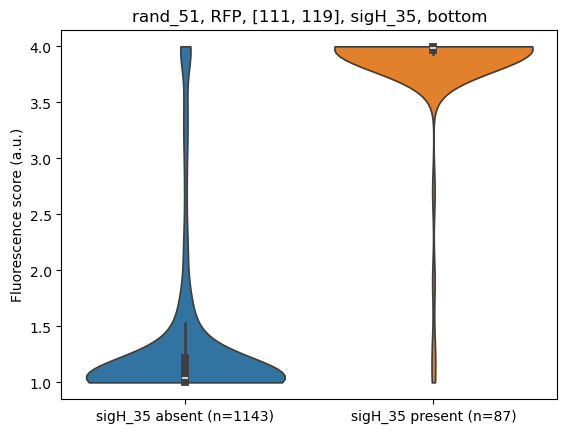

In [71]:
### KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_51'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [111, 119] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'sigH_35' #string: 'minus10' or 'minus35'

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
plt.savefig('Fig_S7k.pdf')

In [72]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor      PWM       P-value         ROI  N_without  \
2369      bottom  rand_51   RFP  sigH_35  1.629092e-49  [111, 119]       1143   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
2369      87       1.038339    3.986108  1.054837e-46    True      gain   

      fluorescence_change  
2369             2.947769

### S7L
Genomic parent #85 gains a σH -35 box

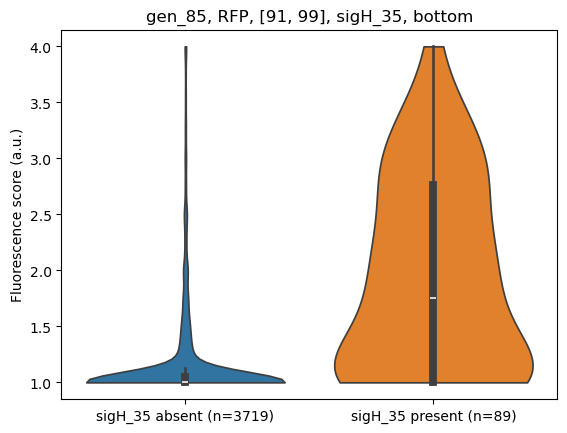

In [73]:
## KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_85'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [91, 99] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'sigH_35' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S7L.pdf')

In [74]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation  Parent Fluor      PWM       P-value       ROI  N_without  \
1215      bottom  gen_85   RFP  sigH_35  2.515341e-29  [91, 99]       3719   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
1215      89            1.0        1.75  3.922273e-28    True      gain   

      fluorescence_change  
1215                 0.75

### S7M
σ28 -35 box

<Figure size 600x300 with 0 Axes>

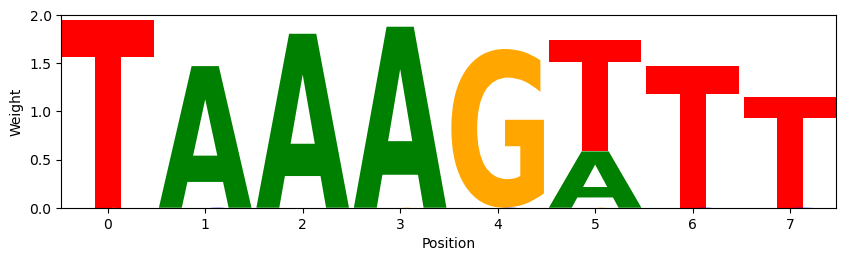

In [345]:
pwm = pd.DataFrame(PSSMs_dict['sigma28_35'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S7M.pdf')

### S7N
Random parent #43 gains a σ28 -35 box

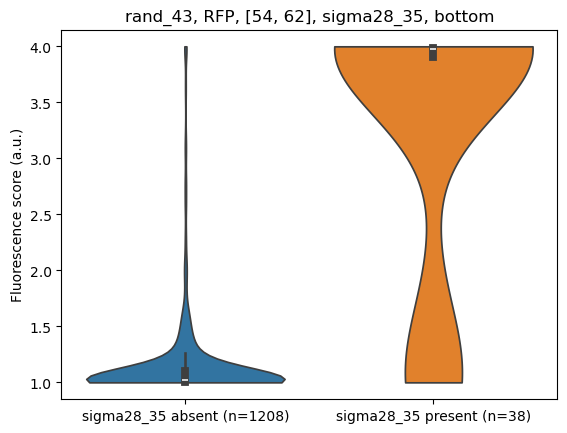

In [75]:
### KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_43'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [54, 62] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'sigma28_35' #string: 'minus10' or 'minus35'

individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)
plt.savefig('Fig_S7N.pdf')

In [76]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor         PWM       P-value       ROI  \
2274      bottom  rand_43   RFP  sigma28_35  1.303156e-16  [54, 62]   

      N_without  N_with  Fluor_without  Fluor_with       Q-value  status  \
2274       1208      38       1.024725    3.977645  4.441017e-15    True   

     gain-loss  fluorescence_change  
2274      gain             2.952919

### S7O
Genomic parent #106 gains a σ28 -35 box

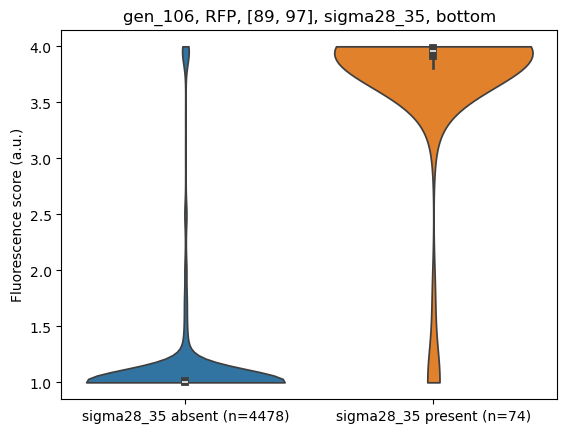

In [77]:
## KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_106'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [89, 97] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'sigma28_35' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S7O.pdf')

In [78]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor         PWM       P-value       ROI  \
1340      bottom  gen_106   RFP  sigma28_35  5.478654e-66  [89, 97]   

      N_without  N_with  Fluor_without  Fluor_with       Q-value  status  \
1340       4478      74            1.0      3.9555  2.429441e-64    True   

     gain-loss  fluorescence_change  
1340      gain               2.9555

# Figure S8

In [348]:
if 'random_repression' not in locals():
    print('please run cell "Fig 4 Dataframes" before proceeding...')
if 'genome_repression' not in locals():
    print('please run cell "Fig 4 Dataframes" before proceeding...')

random_sub_df = random_repression.sort_values(by='fluorescence_change', ascending=False)
genome_sub_df = genome_repression.sort_values(by='fluorescence_change', ascending=False)

### S8A
mutational spectra

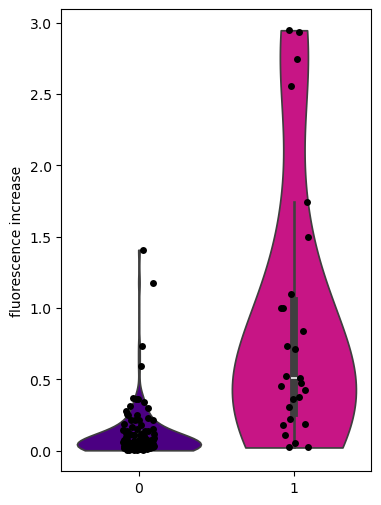

In [79]:
random_sub_df = random_repression.sort_values(by='fluorescence_change', ascending=False)
genome_sub_df = genome_repression.sort_values(by='fluorescence_change', ascending=False)

data = [random_repression['fluorescence_change'].to_list(), genome_repression['fluorescence_change'].to_list()]

plt.figure(figsize=(4,6))
sns.violinplot(data=data, cut=0)

plt.gca().collections[0].set_facecolor('indigo')
plt.gca().collections[1].set_facecolor('mediumvioletred')

sns.stripplot(data=data, color='black')
plt.ylabel('fluorescence increase')

plt.savefig('Fig_S8A.pdf')

### S8B
Random parent #30 loses a IclR site

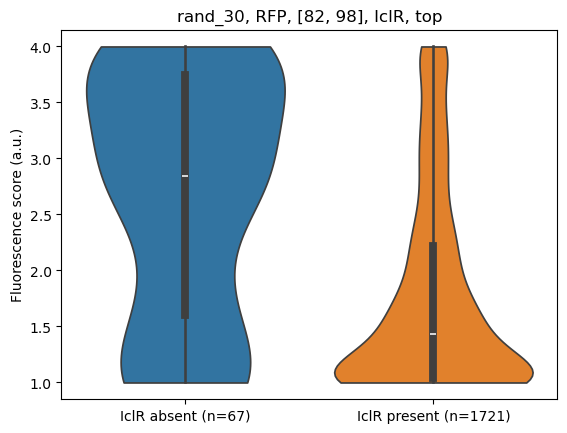

In [80]:
## KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_30'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [82, 98] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'IclR' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8B.pdf')

In [81]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor   PWM       P-value       ROI  N_without  \
801         top  rand_30   RFP  IclR  2.727983e-09  [82, 98]         67   

     N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
801    1721        2.84186    1.433962  3.271054e-08    True      loss   

     fluorescence_change  
801             1.407898

### S8C
Random parent #30 loses a HNS site

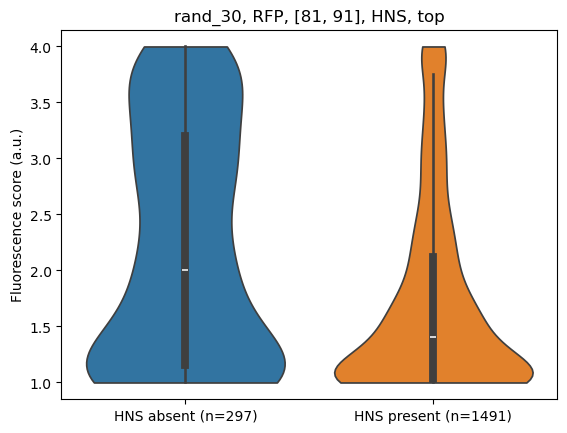

In [82]:
## KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_30'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [81, 91] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'HNS' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8C.pdf')

In [83]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor  PWM       P-value       ROI  N_without  \
2509         top  rand_30   RFP  HNS  5.133012e-12  [81, 91]        297   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
2509    1491            2.0    1.405405  9.564389e-11    True      loss   

      fluorescence_change  
2509             0.594595

### S8D
Random parent #47 loses a CpxR site

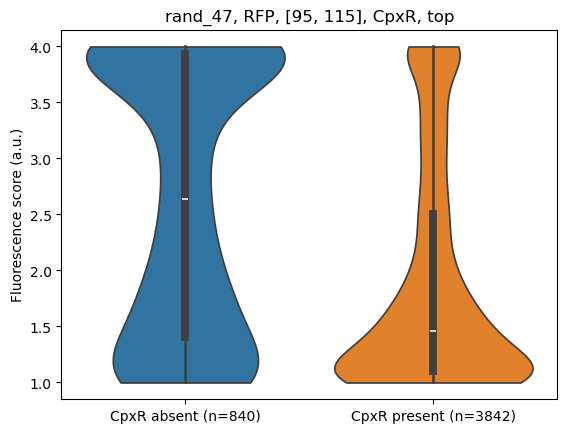

In [84]:
## KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_47'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [95, 115] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'CpxR' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8D.pdf')

In [85]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor   PWM       P-value        ROI  N_without  \
1303         top  rand_47   RFP  CpxR  4.318599e-52  [95, 115]        840   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
1303    3842       2.638937    1.461538  5.592585e-49    True      loss   

      fluorescence_change  
1303             1.177398

### S8E
Random parent #51 loses a IclR site

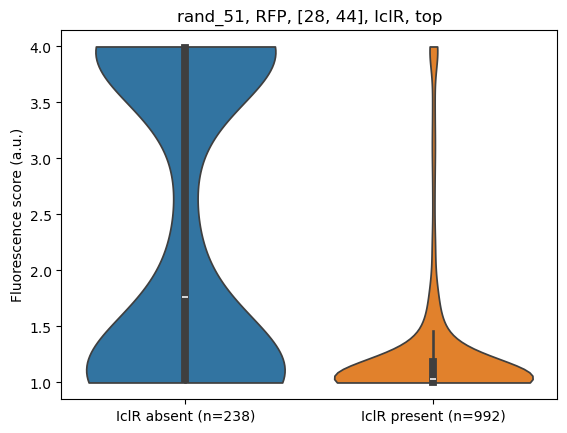

In [86]:
## KWARGS
df = random_mut_df #pandas datafrmae
parent = 'rand_51'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [28, 44] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'IclR' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8E.pdf')

In [87]:
sub_df = random_output[(random_output['PWM'] == TF) & (random_output['Parent'] == parent) & (random_output['Orientation'] == orientation) & (random_output['Fluor'] == fluor) & (random_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor   PWM       P-value       ROI  N_without  \
1425         top  rand_51   RFP  IclR  9.647132e-29  [28, 44]        238   

      N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
1425     992       1.766346    1.035225  1.086351e-26    True      loss   

      fluorescence_change  
1425             0.731121

### S8F
Genomic parent #163 loses a MraZ site

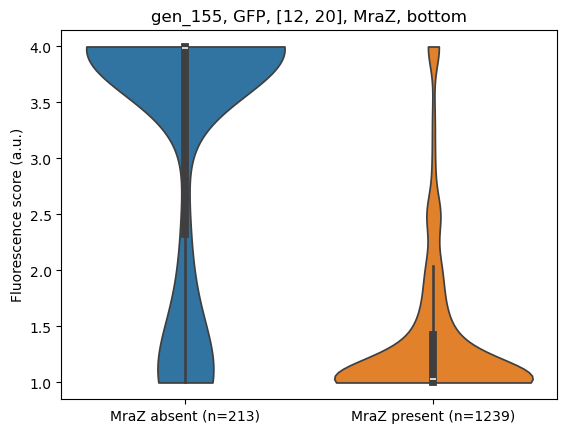

In [88]:
## KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_155'
fluor = 'GFP' #string: 'RFP' or 'GFP'
ROI = [12, 20] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'MraZ' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8F.pdf')

In [89]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor   PWM       P-value       ROI  N_without  \
507      bottom  gen_155   GFP  MraZ  6.832070e-65  [12, 20]        213   

     N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
507    1239       3.982353    1.035294  2.937790e-63    True      loss   

     fluorescence_change  
507             2.947059

### S8G
Genomic parent #163 loses a DnaA site

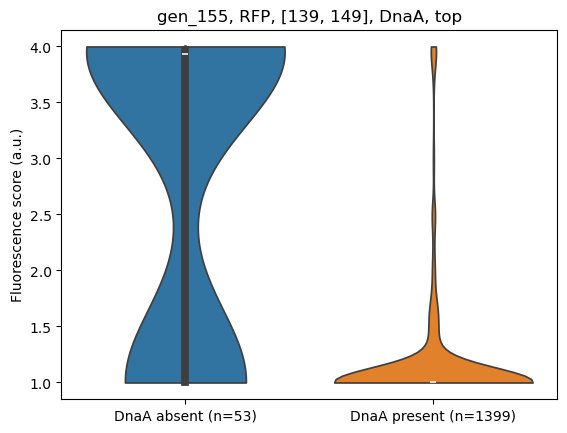

In [90]:
## KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_155'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [139, 149] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'DnaA' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8G.pdf')

In [91]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor   PWM       P-value         ROI  N_without  \
486         top  gen_155   RFP  DnaA  1.046610e-19  [139, 149]         53   

     N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
486    1399       3.934211         1.0  1.060814e-18    True      loss   

     fluorescence_change  
486             2.934211

### S8H
Genomic parent #155 loses a FlhDC site

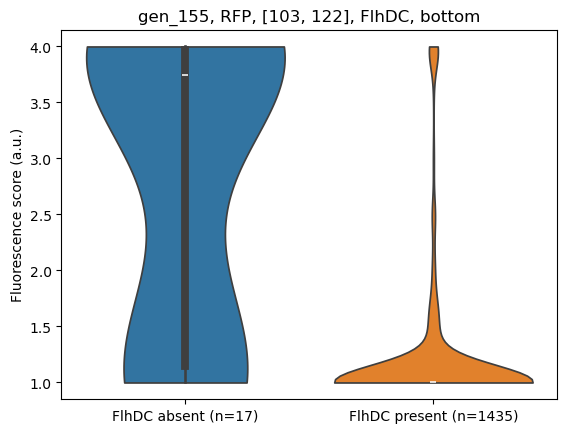

In [92]:
## KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_155'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [103, 122] #list
orientation = 'bottom' #string: 'top' or 'bottom'
TF = 'FlhDC' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8H.pdf')

In [93]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor    PWM       P-value         ROI  N_without  \
472      bottom  gen_155   RFP  FlhDC  2.019990e-09  [103, 122]         17   

     N_with  Fluor_without  Fluor_with       Q-value  status gain-loss  \
472    1435        3.74477         1.0  8.607706e-09    True      loss   

     fluorescence_change  
472              2.74477

### S8I
Genomic parent #216 loses a MraZ site

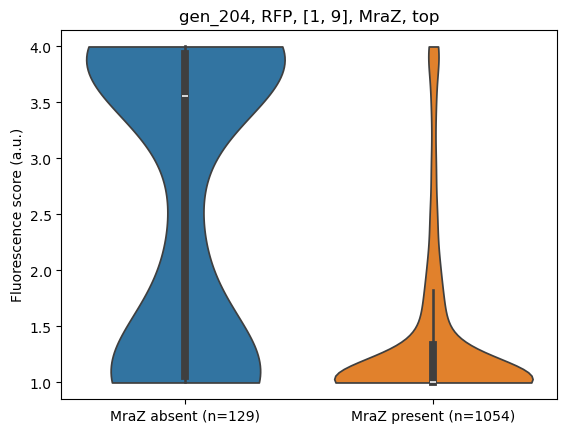

In [94]:
## KWARGS
df = genome_mut_df #pandas datafrmae
parent = 'gen_204'
fluor = 'RFP' #string: 'RFP' or 'GFP'
ROI = [1, 9] #list
orientation = 'top' #string: 'top' or 'bottom'
TF = 'MraZ' #string: 'minus10' or 'minus35'
individual_gain_loss_PWM_plots(df, parent, fluor, ROI, orientation, TF)

plt.savefig('Fig_S8I.pdf')

In [95]:
sub_df = genome_output[(genome_output['PWM'] == TF) & (genome_output['Parent'] == parent) & (genome_output['Orientation'] == orientation) & (genome_output['Fluor'] == fluor) & (genome_output['ROI'] == str(ROI))]
sub_df

Orientation   Parent Fluor   PWM       P-value     ROI  N_without  N_with  \
413         top  gen_204   RFP  MraZ  1.596189e-24  [1, 9]        129    1054   

     Fluor_without  Fluor_with       Q-value  status gain-loss  \
413       3.553719         1.0  2.004417e-23    True      loss   

     fluorescence_change  
413             2.553719

### S8J
sequence logos

<Figure size 600x300 with 0 Axes>

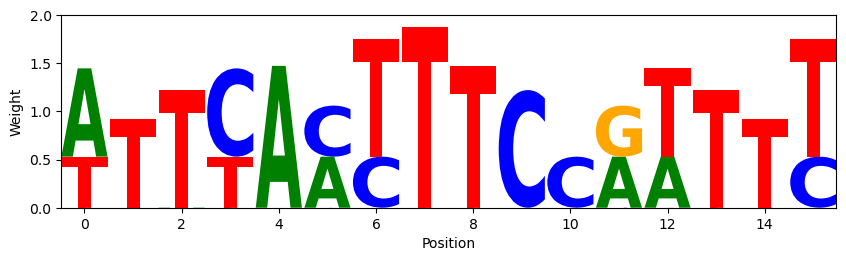

In [358]:
pwm = pd.DataFrame(PSSMs_dict['IclR'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S8J_IclR.pdf')

<Figure size 600x300 with 0 Axes>

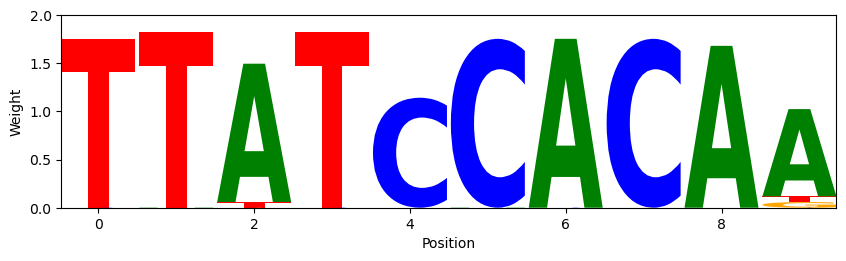

In [359]:
pwm = pd.DataFrame(PSSMs_dict['DnaA'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S8J_DnaA.pdf')

<Figure size 600x300 with 0 Axes>

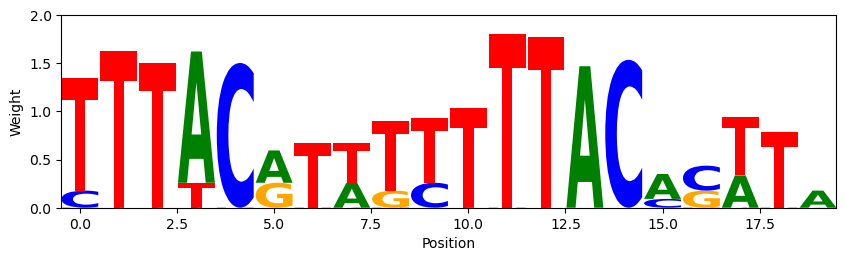

In [360]:
pwm = pd.DataFrame(PSSMs_dict['CpxR'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S8J_CpxR.pdf')

<Figure size 600x300 with 0 Axes>

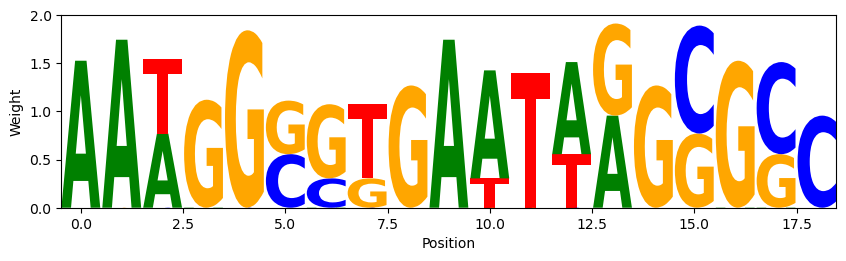

In [361]:
pwm = pd.DataFrame(PSSMs_dict['FlhDC'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S8J_FlhDC.pdf')

<Figure size 600x300 with 0 Axes>

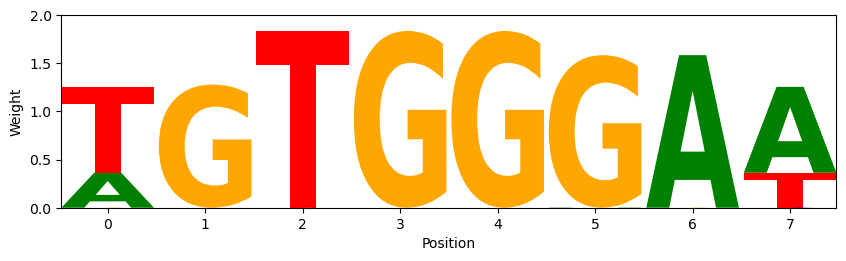

In [362]:
pwm = pd.DataFrame(PSSMs_dict['MraZ'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S8J_MraZ.pdf')

<Figure size 600x300 with 0 Axes>

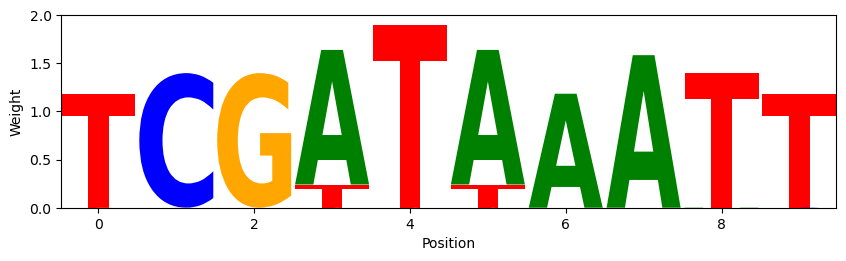

In [363]:
pwm = pd.DataFrame(PSSMs_dict['HNS'])

# Create the logo
plt.figure(figsize=(6, 3)) #6 = length of the motif
logomaker.Logo(pwm)

# Customize appearance (optional)
#plt.title("sigma 70 -10 box")
plt.xlabel("Position")
plt.ylabel("Weight")
plt.ylim(0,2)

plt.savefig('Fig_S8J_HNS.pdf')

# Figure S10

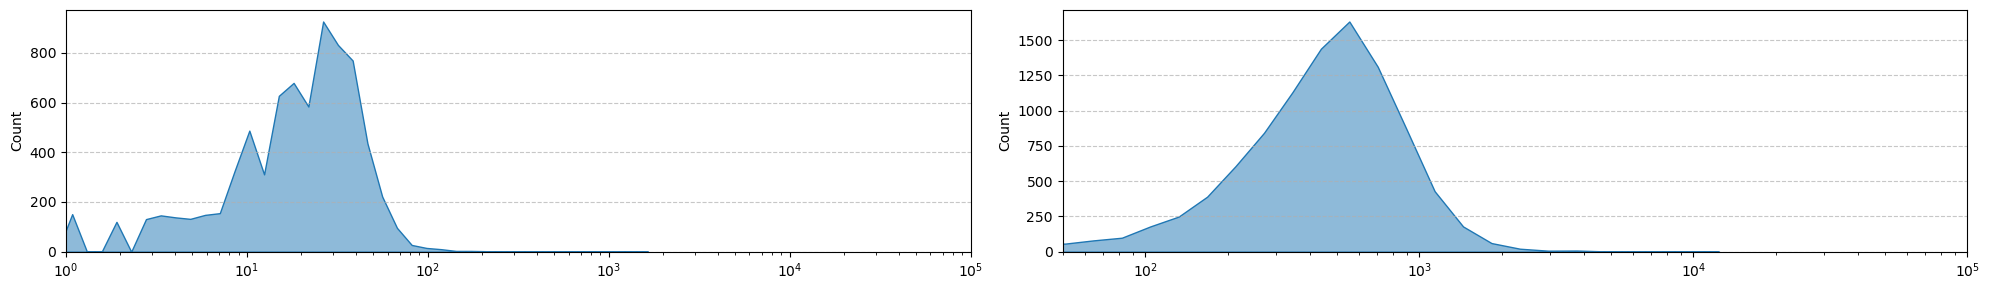

In [364]:
### Negative controls
# Create a single figure with two axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

facsplot('fcs/controls/empty.fcs', ax1, ax2)

# Final formatting
ax1.set_xlim([1, 100000])
ax1.yaxis.grid(True, which='both', linestyle='--', alpha=0.7)

ax2.set_xlim([50, 100000])
ax2.yaxis.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('Fig_S10_negative.pdf')

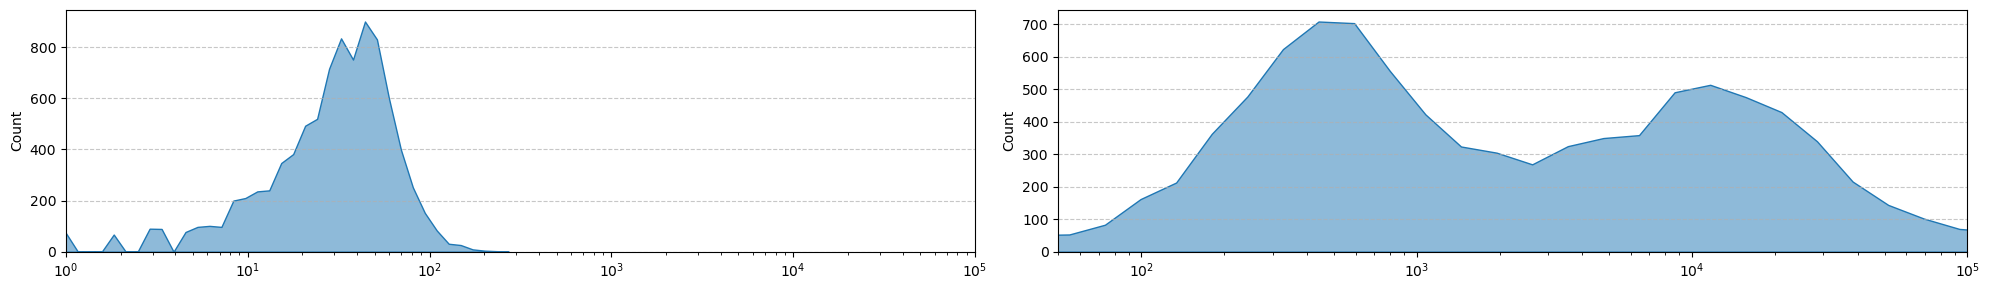

In [365]:
### GFP controls

# Create a single figure with two axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

facsplot('fcs/controls/GFP.fcs', ax1, ax2)

# Final formatting
ax1.set_xlim([1, 100000])
#ax1.invert_xaxis()
ax1.yaxis.grid(True, which='both', linestyle='--', alpha=0.7)

ax2.set_xlim([50, 100000])
ax2.yaxis.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('Fig_S10_gfp_control.pdf')

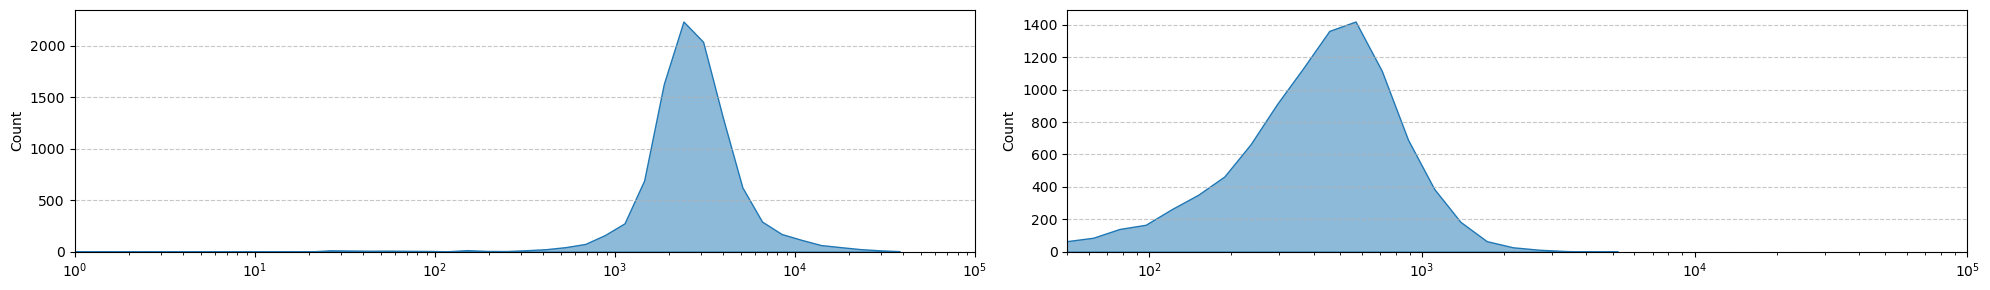

In [366]:
### RFP controls

# Create a single figure with two axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

facsplot('fcs/controls/RFP.fcs', ax1, ax2)

# Final formatting
ax1.set_xlim([1, 100000])
#ax1.invert_xaxis()
ax1.yaxis.grid(True, which='both', linestyle='--', alpha=0.7)

ax2.set_xlim([50, 100000])
ax2.yaxis.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('Fig_S10_rfp_control.pdf')